<a href="https://colab.research.google.com/github/jojosobaka/testNeuro/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В задании используется база курса акций Лукойла.

1. Обучите простую полносвязную сеть для прогнозирования временного ряда (только close) и визуализируйте результат.

2. Обучите такую же архитектуру сети на прогнозирование на 10 шагов вперёд прямым способом и визуализируйте результат.

3. Постройте графики сравнения предсказания с оригинальным сигналом по всем 10 шагам предсказания (10 графиков на разных отдельных осях).

4. Сделайте те же задания с другой сетью, которая будет использовать Conv1D или LSTM слои.


## Подготовка данных

### Загрузка библиотек

In [ ]:
import numpy as np                                                      # Работа с массивами
import pandas as pd                                                     # Работа с таблицами
from tensorflow.keras.models import Sequential, Model                   # Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM, MaxPooling1D # Основные слои
from tensorflow.keras.optimizers import Adam                            # Оптимизаторы
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Генератор выборки временных рядов
from sklearn.preprocessing import StandardScaler, MinMaxScaler          # Нормировщики
import gdown                                                            # Загрузка датасетов из облака google
import matplotlib.pyplot as plt                                         # Отрисовка графиков
from pylab import rcParams                                              # Назначение размера и стиля графиков по умолчанию
import warnings
warnings.filterwarnings('ignore')                                       # Отключение предупреждений
plt.style.use('ggplot')                                                 # Назначение размера и стиля графиков по умолчанию
rcParams['figure.figsize'] = (14, 7)
# Отрисовка графики в ячейке colab
%matplotlib inline

### Загрузка базы

In [ ]:
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/16_17.csv', None, quiet=True)
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/18_19.csv', None, quiet=True)
data16_17 = pd.read_csv('16_17.csv', sep=';').drop(columns=['DATE', 'TIME'])  # Загрузка датасетов с удалением ненужных столбцов по дате и времени
data18_19 = pd.read_csv('18_19.csv', sep=';').drop(columns=['DATE', 'TIME'])

data = pd.concat([data16_17, data18_19]).to_numpy() # Создание общего набора данных из двух датасетов
print(data16_17.head())
print(data.shape)

### Иллюстрация данных в графическом виде

In [ ]:
channel_names = ['Open', 'Max', 'Min', 'Close', 'Volume'] # Задание текстовых меток каналов данных (столбцов)
start = 100   # Отображение исходных данных от точки start и длинной length
length = 300

fig, ax = plt.subplots(figsize=(22, 10), sharex=True) # Задание полотна для графиков - два подграфика один под другим с общей осью x


for chn in range(4):    # Четыре основных канала - open, max, min, close
    ax.plot(data[start:start + length, chn],  # Отрисовка одного канала данных
             label=channel_names[chn])        # От начальной точки start длиной length
ax.set_ylabel('Цена, руб')
ax.legend()
plt.xlabel('Время')
plt.xlim(0, length) # Регулировка пределов оси x
plt.tight_layout()  # Указание расположить подграфики плотнее друг к другу
plt.show()          # Фиксация графика

# Подготовка базы

In [ ]:
CHANNEL_NAMES = ['Open', 'Max', 'Min', 'Close', 'Volume'] # Задание текстовых меток каналов данных (столбцов)
CHANNEL_INDEX = {name: chan for chan, name in enumerate(CHANNEL_NAMES)} # Получение словаря с именами и индексами каналов данных
print("CHANNEL_INDEX: ", CHANNEL_INDEX)

CHANNEL_X = CHANNEL_NAMES                 # Отбор каналов входных данных
CHANNEL_Y = ['Close']                     # Отбор каналов данных для предсказания
SEQ_LEN = 300                             # Длина прошедших данных для анализа
BATCH_SIZE = 20                           # Объем батча для генератора
TEST_LEN = 30000                          # Объем тестовой выборки
TRAIN_LEN = data.shape[0] - TEST_LEN      # Объем обучающей выборки


chn_x = [CHANNEL_INDEX[c] for c in CHANNEL_X] # Формирование списков индексов каналов данных для входных и выходных выборок
chn_y = [CHANNEL_INDEX[c] for c in CHANNEL_Y]
print("chn_x, chn_y: ", chn_x, chn_y)                           # Проверка результата

data_train, data_test = data[:TRAIN_LEN], data[TRAIN_LEN + 2*SEQ_LEN:]  # Разделение данных на тренировочный и тестовый наборы (2*SEQ_LEN - для разрыва между тренировочными и тестовыми данными, варьируемый параметр, страховка от пересечения)
x_data_train, x_data_test = data_train[:, chn_x], data_test[:, chn_x]   # Отбор входных данных

x_scaler = MinMaxScaler()
x_scaler.fit(x_data_train)
x_data_train = x_scaler.transform(x_data_train)
x_data_test = x_scaler.transform(x_data_test)

y_data_train, y_data_test = data_train[:, chn_y], data_test[:, chn_y] # Отбор выходных данных

y_scaler = MinMaxScaler()
y_scaler.fit(y_data_train)
y_data_train = y_scaler.transform(y_data_train)
y_data_test = y_scaler.transform(y_data_test)

print(f'Train data: {x_data_train.shape}, {y_data_train.shape}')    # Проверка формы данных
print(f'Test  data: {x_data_test.shape}, {y_data_test.shape}')


train_datagen = TimeseriesGenerator(x_data_train, # Создание генератора для обучения
                                    y_data_train,
                                    length=SEQ_LEN,
                                    stride=1,
                                    sampling_rate=1,
                                    batch_size=BATCH_SIZE)


val_datagen = TimeseriesGenerator(x_data_test,    # Аналогичный генератор для валидации при обучении
                                  y_data_test,
                                  length=SEQ_LEN,
                                  stride=1,
                                  sampling_rate=1,
                                  batch_size=BATCH_SIZE)


print(f'Train batch x: {train_datagen[0][0].shape}, y: {train_datagen[0][1].shape}')  # Проверка формы выдаваемого генератором результата

test_datagen = TimeseriesGenerator(x_data_test,   # Генератор тестовой выборки, генерирует один батч на всю выборку
                                   y_data_test,
                                   length=SEQ_LEN,
                                   stride=1,
                                   sampling_rate=1,
                                   batch_size=x_data_test.shape[0])

x_test, y_test = test_datagen[0]                    # Формирование тестовой выборки из генератора
print(f'Test x: {x_test.shape}, y: {y_test.shape}') # Проверка формы тестовой выборки

CHANNEL_INDEX:  {'Open': 0, 'Max': 1, 'Min': 2, 'Close': 3, 'Volume': 4}
chn_x, chn_y:  [0, 1, 2, 3, 4] [3]
Train data: (451872, 5), (451872, 1)
Test  data: (29400, 5), (29400, 1)
Train batch x: (20, 300, 5), y: (20, 1)
Test x: (29100, 300, 5), y: (29100, 1)


## Просто пытаюсь понять с что внутри (прост принты, глупый дебаг)

In [ ]:
# for i, g in enumerate(train_datagen):
        # print('Батч №', i)
        # print('x_train:\n', g[0])
        # print('y_train:\n', g[1])
        # print()

In [ ]:
for i, g in enumerate(val_datagen):
        print('Батч №', i)
        print('x_train:\n', g[0])
        print('y_train:\n', g[1])
        print()

Streaming output truncated to the last 5000 lines.
   6.33096861e-05]]

 [[8.17802503e-01 8.17426755e-01 8.17855246e-01 8.17441655e-01
   2.27635562e-04]
  [8.17296751e-01 8.17173533e-01 8.17728756e-01 8.17062378e-01
   5.91200745e-05]
  [8.17170312e-01 8.16793700e-01 8.17096309e-01 8.16556677e-01
   2.62083480e-04]
  ...
  [8.14262233e-01 8.13881644e-01 8.13175137e-01 8.13522466e-01
   4.02435468e-04]
  [8.13630042e-01 8.13628422e-01 8.14187053e-01 8.13901742e-01
   6.33096861e-05]
  [8.14009356e-01 8.14008255e-01 8.14187053e-01 8.13901742e-01
   1.41748525e-04]]

 [[8.17296751e-01 8.17173533e-01 8.17728756e-01 8.17062378e-01
   5.91200745e-05]
  [8.17170312e-01 8.16793700e-01 8.17096309e-01 8.16556677e-01
   2.62083480e-04]
  [8.16664559e-01 8.16540478e-01 8.17222798e-01 8.16809527e-01
   5.05080951e-05]
  ...
  [8.13630042e-01 8.13628422e-01 8.14187053e-01 8.13901742e-01
   6.33096861e-05]
  [8.14009356e-01 8.14008255e-01 8.14187053e-01 8.13901742e-01
   1.41748525e-04]
  [8.1400935

In [ ]:
y_data_test[301]

array([0.78532959])

In [ ]:
x_data_test[301]

array([7.86066507e-01, 7.85647363e-01, 7.85600445e-01, 7.85329591e-01,
       3.66358257e-04])

In [ ]:
val_datagen.data[301]

array([7.86066507e-01, 7.85647363e-01, 7.85600445e-01, 7.85329591e-01,
       3.66358257e-04])

In [ ]:
x_test[1]

array([[7.74939942e-01, 7.74505584e-01, 7.74848845e-01, 7.74204152e-01,
        1.62463827e-04],
       [7.74560627e-01, 7.74632195e-01, 7.74848845e-01, 7.74836279e-01,
        4.46659146e-04],
       [7.74939942e-01, 7.75645084e-01, 7.75354803e-01, 7.75974108e-01,
        5.31382402e-04],
       ...,
       [7.84928562e-01, 7.85014307e-01, 7.84967998e-01, 7.85076740e-01,
        5.31382402e-04],
       [7.84928562e-01, 7.85014307e-01, 7.84967998e-01, 7.85076740e-01,
        5.68623394e-04],
       [7.84928562e-01, 7.85647363e-01, 7.85473956e-01, 7.85961718e-01,
        5.62571733e-04]])

In [ ]:
y_test[2]

array([0.78444461])

In [ ]:
test_datagen.data.shape

(29400, 5)

## Сервисные функции

In [ ]:
# Функция визуализации результата предсказания сети и верных ответов
def show_predict(y_pred, y_true,      # прогноз данных и исходный ряд
                 start,               # точка ряда, с которой начинается отрисовка графика
                 length,              # количество точек для отрисовки графика
                 chn_list=None,       # список каналов данных для отрисовки (по умолчанию все)
                 chn_names=CHANNEL_Y, # список имен каналов данных
                 title=''):

    if not chn_list:                                # Если список каналов пуст - отображаются все каналы
        chn_list = list(range(y_true.shape[1]))

    plt.figure(figsize=(22, 6))                     # Построение графика по всем каналам данных

    for chn in chn_list:
        plt.plot(y_pred[start:start + length, chn],
                label=f'{chn_names[chn]} Прогноз')
        plt.plot(y_true[start:start + length, chn],
                label=f'{chn_names[chn]} Базовый')

    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Данные')
    plt.legend()
    plt.show()

In [ ]:
# Функция рисования корреляций прогнозного ряда и исходного со смещением
def show_corr(y_pred, y_true,     # прогноз данных и исходный ряд
              back_steps_max=30,  # максимальное количество шагов смещения назад по времени
              chn_list=None,      # список каналов данных для отрисовки (по умолчанию все)
              chn_names=CHANNEL_Y,
              title=''):          # список имен каналов данных

    def correlate(a, b):                # Функция расчета корреляционного коэффициента Пирсона для двух рядов
        return np.corrcoef(a, b)[0, 1]

    if not chn_list:                            # Если список каналов пуст - отображаются все каналы
        chn_list = list(range(y_true.shape[1]))

    y_len = y_true.shape[0]
    steps = range(0, back_steps_max + 1)

    plt.figure(figsize=(14, 7))                 # Построение графика по всем каналам данных

    for chn in chn_list:
        cross_corr = [correlate(y_true[:y_len - step, chn], y_pred[step:, chn]) for step in steps]  # Вычисление коэффициентов корреляции базового ряда и предсказания с разным смещением
        auto_corr = [correlate(y_true[:y_len - step, chn], y_true[step:, chn]) for step in steps]   # Вычисление коэффициентов автокорреляции базового ряда с разным смещением

        plt.plot(cross_corr, label=f'{chn_names[chn]} Прогноз')
        plt.plot(auto_corr, label=f'{chn_names[chn]} Эталон')

    plt.title(title)
    plt.xticks(steps)                     # Назначение меток шкалы оси x
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()

In [ ]:
# Функция визуализации результата работы сети
def eval_net(model,           # модель
             x_test, y_test,  # тестовая выборка
             y_scaler,        # нормировщик выхода
             start=0, length=500, back_steps_max=30, # параметры отображения графиков
             title=''):

    y_pred = y_scaler.inverse_transform(model.predict(x_test)) # Вычисление и деномализация предсказания
    y_true = y_scaler.inverse_transform(y_test)                # Денормализация верных ответов

    show_predict(y_pred[1:], y_true[:-1], start, length,                        # Отрисовка графика сопоставления базового и прогнозного рядов
                 title=f'{title}: Сопоставление базового и прогнозного рядов')  # Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед

    show_corr(y_pred, y_true, back_steps_max=back_steps_max,                    # Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
              title=f'{title}: Корреляционные коэффициенты по шагам смещения')

In [ ]:
# Функция обучения модели и отрисовки прогресса и оценки результатов
def train_eval_net(model,                       # модель
                   train_datagen, val_datagen,  # генераторы обучающей и проверочной выборок
                   epoch_list,                  # список эпох в виде [(epochs1, opt1), (epochs2, opt2), ...]
                   x_test, y_test,
                   y_scaler,
                   start=0,
                   length=500,
                   back_steps_max=30,
                   title=''):

    for epochs, opt in epoch_list:                # Обучение модели в несколько фаз в соответствии со списком epoch_list
        model.compile(loss='mse', optimizer=opt)  # Компиляция модели
        print(f'Обучение {epochs} эпох')          # Фаза обучения модели
        history = model.fit(train_datagen,
                            epochs=epochs,
                            validation_data=val_datagen,
                            verbose=1)

        fig = plt.figure(figsize=(14, 7))                                       # Рисование графиков прошедшей фазы обучения
        plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
        plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
        plt.title(f'{title}: График прогресса обучения')
        fig.gca().xaxis.get_major_locator().set_params(integer=True)            # Указание показывать только целые метки шкалы оси x
        plt.xlabel('Эпоха обучения')
        plt.ylabel('Средняя ошибка')
        plt.legend()
        plt.show()

        eval_net(model, x_test, y_test, y_scaler, start=start,                  # Рисование графиков оценки результата работы модели после фазы обучения
                 length=length, back_steps_max=back_steps_max, title=title)

# Построение архитектуры и Обучение нейронки

Обучение 50 эпох
Epoch 1/50
22579/22579 [==============================] - 240s 11ms/step - loss: 0.0032 - val_loss: 3.1991e-05
Epoch 2/50
22579/22579 [==============================] - 226s 10ms/step - loss: 2.3329e-04 - val_loss: 1.4458e-05
Epoch 3/50
22579/22579 [==============================] - 213s 9ms/step - loss: 1.9363e-04 - val_loss: 0.0019
Epoch 4/50
22579/22579 [==============================] - 216s 10ms/step - loss: 2.1206e-04 - val_loss: 1.3544e-04
Epoch 5/50
22579/22579 [==============================] - 205s 9ms/step - loss: 2.2660e-04 - val_loss: 1.3898e-05
Epoch 6/50
22579/22579 [==============================] - 213s 9ms/step - loss: 2.0330e-04 - val_loss: 1.1416e-04
Epoch 7/50
22579/22579 [==============================] - 218s 10ms/step - loss: 1.9344e-04 - val_loss: 0.0014
Epoch 8/50
22579/22579 [==============================] - 216s 10ms/step - loss: 2.0592e-04 - val_loss: 2.7252e-05
Epoch 9/50
22579/22579 [==============================] - 211s 9ms/step - loss

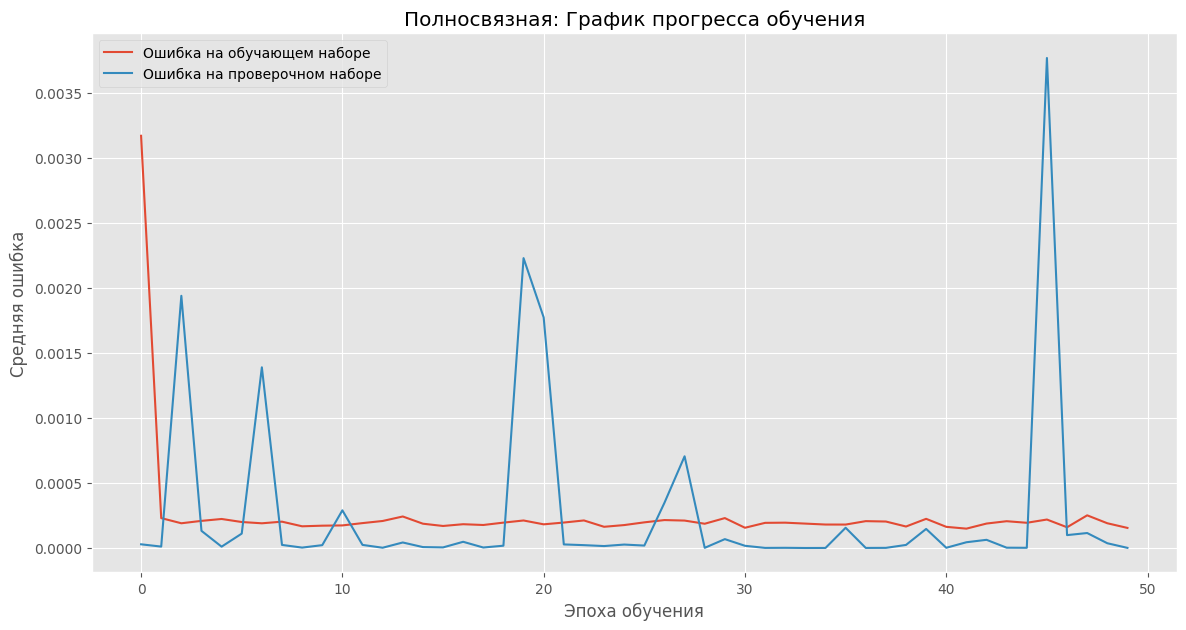

910/910 [==============================] - 6s 7ms/step


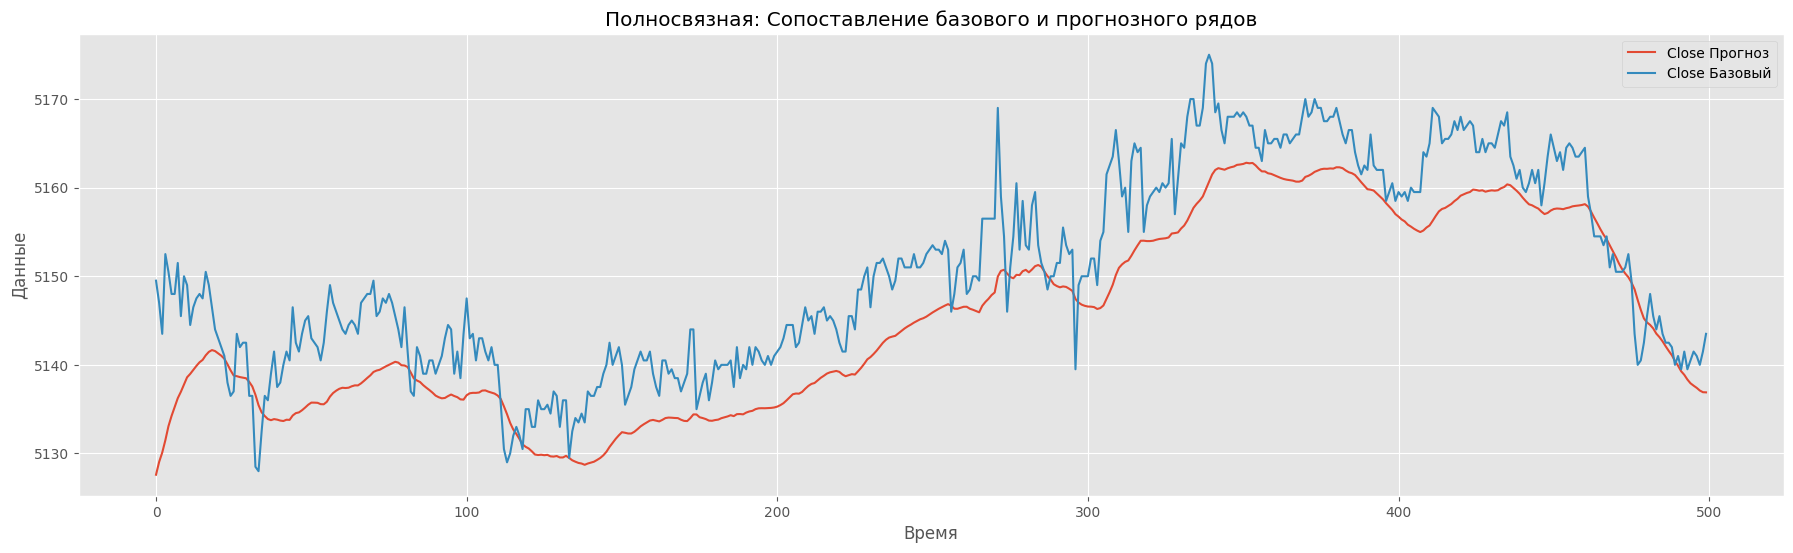

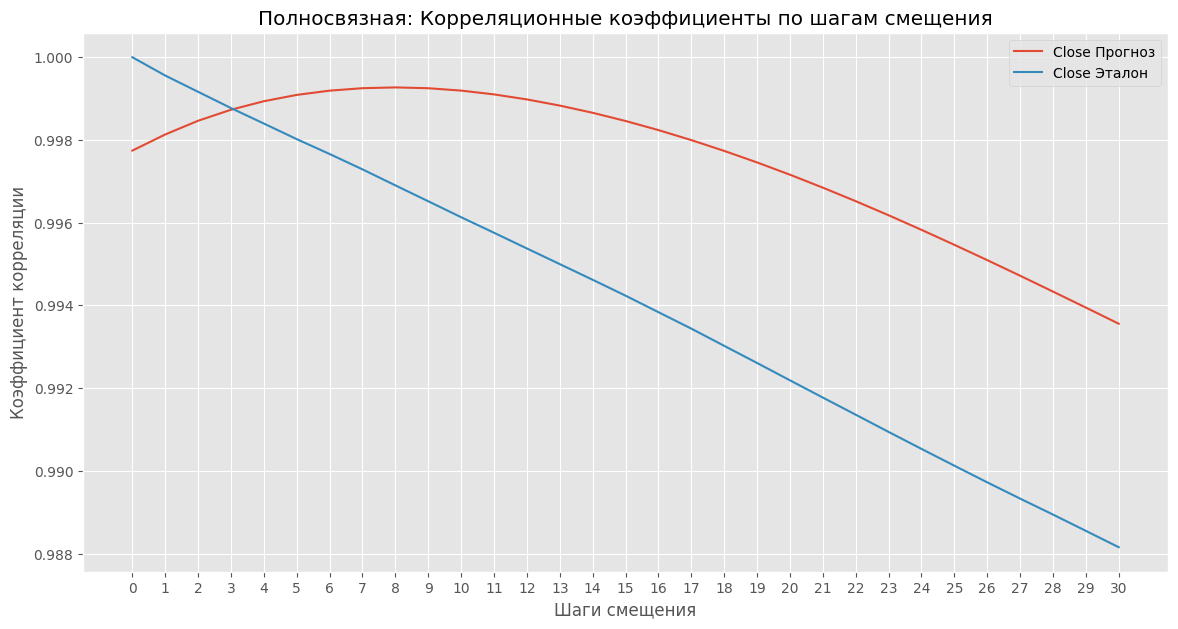

In [ ]:
# Простая полносвязная сеть (сама архитектура)
model_dense = Sequential()
model_dense.add(Dense(150, input_shape=x_test.shape[1:], activation='relu'))
model_dense.add(Flatten())
model_dense.add(Dense(y_test.shape[1], activation='linear'))

# Обучение модели 3x50 эпох
train_eval_net(model_dense, train_datagen, val_datagen, [(50, Adam(lr=1e-6))],
               x_test, y_test, y_scaler, title='Полносвязная')

# 2. Обучаю такую же архитектуру сети на прогнозирование на 10 шагов вперёд прямым способом.

## Пытаюсь понять что за шаг и как его впихнуть

In [ ]:
# эта ячейка colab, значит шаг
x_t = [
    5.6, 4.7, 5.2, 9.1,
    7.1, 5.1, 6.1, 9.2,
    8.2, 5.6, 6.4, 9.5,
    9.1, 6.7, 7.5, 9.9
    ]

x_t_np = np.array(x_t[1:])
x_t_1_np = np.array(x_t[:-1])

print(x_t_np)
print(x_t_1_np)

[4.7 5.2 9.1 7.1 5.1 6.1 9.2 8.2 5.6 6.4 9.5 9.1 6.7 7.5 9.9]
[5.6 4.7 5.2 9.1 7.1 5.1 6.1 9.2 8.2 5.6 6.4 9.5 9.1 6.7 7.5]


In [ ]:
test_array = np.arange(50)  # Создание и вывод модельного массива (последовательность чисел от 0 до 49)

def show_gen(x_train, y_train, length=10, batch_size=5):  # Функция демонстрации генератора
    gen = TimeseriesGenerator(x_train,
                              y_train,
                              length=length,
                              sampling_rate=1,
                              stride=1,
                              batch_size=batch_size
                             )

    # Прохождение по элементам генератора (батчам) в цикле и вывод каждого батча
    for i, g in enumerate(gen):
        print('Батч №', i)
        print('x_train:\n', g[0])
        print('y_train:\n', g[1])
        print()


show_gen(test_array, test_array, batch_size=1)  # Вывод генератора на модельных выборках (пакет размером с 1 чтобы я мог увидеть разницу)

Батч № 0
x_train:
 [[0 1 2 3 4 5 6 7 8 9]]
y_train:
 [10]

Батч № 1
x_train:
 [[ 1  2  3  4  5  6  7  8  9 10]]
y_train:
 [11]

Батч № 2
x_train:
 [[ 2  3  4  5  6  7  8  9 10 11]]
y_train:
 [12]

Батч № 3
x_train:
 [[ 3  4  5  6  7  8  9 10 11 12]]
y_train:
 [13]

Батч № 4
x_train:
 [[ 4  5  6  7  8  9 10 11 12 13]]
y_train:
 [14]

Батч № 5
x_train:
 [[ 5  6  7  8  9 10 11 12 13 14]]
y_train:
 [15]

Батч № 6
x_train:
 [[ 6  7  8  9 10 11 12 13 14 15]]
y_train:
 [16]

Батч № 7
x_train:
 [[ 7  8  9 10 11 12 13 14 15 16]]
y_train:
 [17]

Батч № 8
x_train:
 [[ 8  9 10 11 12 13 14 15 16 17]]
y_train:
 [18]

Батч № 9
x_train:
 [[ 9 10 11 12 13 14 15 16 17 18]]
y_train:
 [19]

Батч № 10
x_train:
 [[10 11 12 13 14 15 16 17 18 19]]
y_train:
 [20]

Батч № 11
x_train:
 [[11 12 13 14 15 16 17 18 19 20]]
y_train:
 [21]

Батч № 12
x_train:
 [[12 13 14 15 16 17 18 19 20 21]]
y_train:
 [22]

Батч № 13
x_train:
 [[13 14 15 16 17 18 19 20 21 22]]
y_train:
 [23]

Батч № 14
x_train:
 [[14 15 16 17 18 19 

In [ ]:
show_gen(test_array[10:], test_array[:-10], batch_size=1)

Батч № 0
x_train:
 [[10 11 12 13 14 15 16 17 18 19]]
y_train:
 [10]

Батч № 1
x_train:
 [[11 12 13 14 15 16 17 18 19 20]]
y_train:
 [11]

Батч № 2
x_train:
 [[12 13 14 15 16 17 18 19 20 21]]
y_train:
 [12]

Батч № 3
x_train:
 [[13 14 15 16 17 18 19 20 21 22]]
y_train:
 [13]

Батч № 4
x_train:
 [[14 15 16 17 18 19 20 21 22 23]]
y_train:
 [14]

Батч № 5
x_train:
 [[15 16 17 18 19 20 21 22 23 24]]
y_train:
 [15]

Батч № 6
x_train:
 [[16 17 18 19 20 21 22 23 24 25]]
y_train:
 [16]

Батч № 7
x_train:
 [[17 18 19 20 21 22 23 24 25 26]]
y_train:
 [17]

Батч № 8
x_train:
 [[18 19 20 21 22 23 24 25 26 27]]
y_train:
 [18]

Батч № 9
x_train:
 [[19 20 21 22 23 24 25 26 27 28]]
y_train:
 [19]

Батч № 10
x_train:
 [[20 21 22 23 24 25 26 27 28 29]]
y_train:
 [20]

Батч № 11
x_train:
 [[21 22 23 24 25 26 27 28 29 30]]
y_train:
 [21]

Батч № 12
x_train:
 [[22 23 24 25 26 27 28 29 30 31]]
y_train:
 [22]

Батч № 13
x_train:
 [[23 24 25 26 27 28 29 30 31 32]]
y_train:
 [23]

Батч № 14
x_train:
 [[24 25 26

А что мне надо? мда, и ничерта не понятно как вся эта тема... я уже без понятия где и что искать, впрочем это продолжается уже 3й день, надо хоть что-то сделать, мб мне объяснят. Ну или просто глянут правильно я сделал или нет

In [ ]:
x_data_train[0]

array([0.07839171, 0.07822035, 0.07839814, 0.07810564, 0.00059283])

In [ ]:
y_data_train[0]

array([0.07810564])

впрочем они соответствуют можно выкинуть этим пайтоновским двоеточием.

In [ ]:
train_datagen_10step = TimeseriesGenerator(x_data_train[10:], # Создание генератора для обучения
                                    y_data_train[:-10],
                                    length=SEQ_LEN,
                                    stride=1,
                                    sampling_rate=1,
                                    batch_size=BATCH_SIZE)


val_datagen_10step = TimeseriesGenerator(x_data_test[10:],    # Аналогичный генератор для валидации при обучении
                                  y_data_test[:-10],
                                  length=SEQ_LEN,
                                  stride=1,
                                  sampling_rate=1,
                                  batch_size=BATCH_SIZE)

## Обучение нейронки на 10 шагов назад похоже.

Обучение 50 эпох
Epoch 1/50
22579/22579 [==============================] - 191s 8ms/step - loss: 1.6850e-04 - val_loss: 2.9776e-06
Epoch 2/50
22579/22579 [==============================] - 195s 9ms/step - loss: 2.0544e-04 - val_loss: 1.0033e-06
Epoch 3/50
22579/22579 [==============================] - 190s 8ms/step - loss: 1.3909e-04 - val_loss: 5.9132e-04
Epoch 4/50
22579/22579 [==============================] - 188s 8ms/step - loss: 1.7496e-04 - val_loss: 1.0879e-06
Epoch 5/50
22579/22579 [==============================] - 198s 9ms/step - loss: 1.2893e-04 - val_loss: 5.4272e-05
Epoch 6/50
22579/22579 [==============================] - 196s 9ms/step - loss: 1.5019e-04 - val_loss: 7.1519e-06
Epoch 7/50
22579/22579 [==============================] - 193s 9ms/step - loss: 1.7586e-04 - val_loss: 3.5234e-06
Epoch 8/50
22579/22579 [==============================] - 195s 9ms/step - loss: 1.9524e-04 - val_loss: 3.9581e-06
Epoch 9/50
22579/22579 [==============================] - 202s 9ms/step

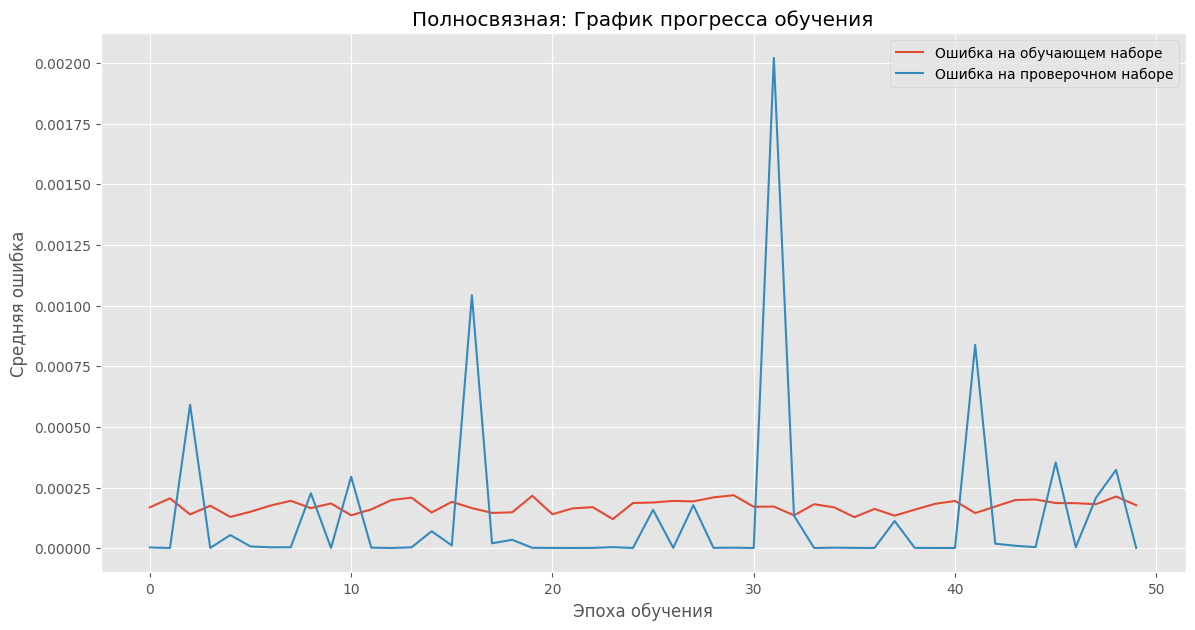

910/910 [==============================] - 5s 5ms/step


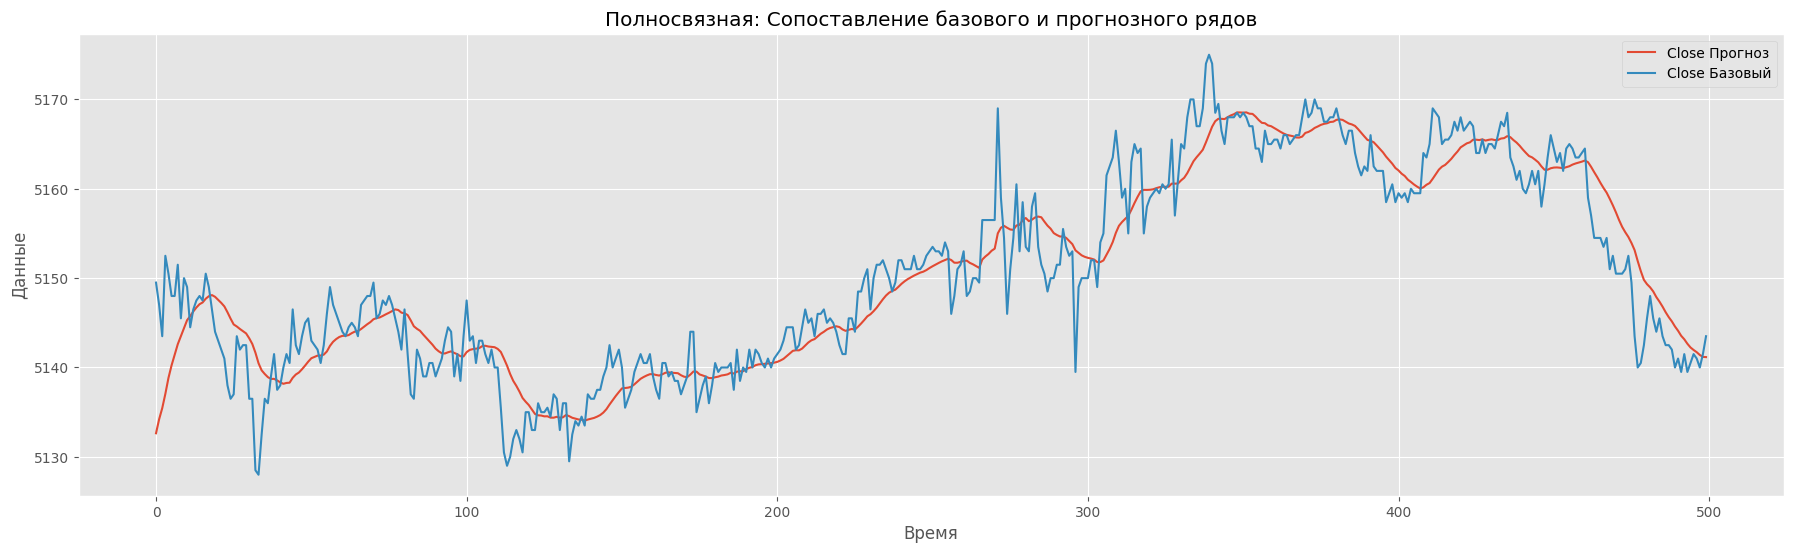

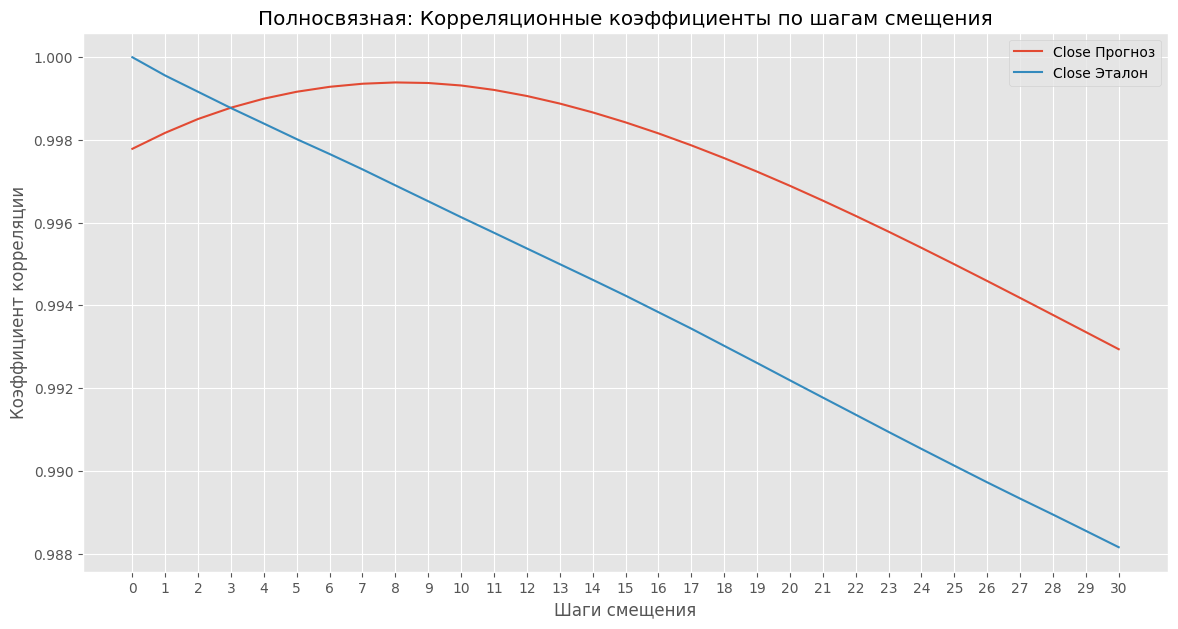

In [ ]:
# Обучение модели 3x50 эпох
train_eval_net(model_dense, train_datagen_10step, val_datagen_10step, [(50, Adam(lr=1e-6))],
               x_test, y_test, y_scaler, title='Полносвязная')

чёт вообще ничего не поменялось

я посмотрел видеоурок на эту тему и шаг про который тут говориться я задал правильно, вроде... я так и не понял, в одном месте говорит назад в другом что это влево. по моим тестам данных я видел что это назад.

In [ ]:
show_gen(test_array[:-10], test_array[10:], batch_size=1) # вот похоже вперёд шаг

Батч № 0
x_train:
 [[0 1 2 3 4 5 6 7 8 9]]
y_train:
 [20]

Батч № 1
x_train:
 [[ 1  2  3  4  5  6  7  8  9 10]]
y_train:
 [21]

Батч № 2
x_train:
 [[ 2  3  4  5  6  7  8  9 10 11]]
y_train:
 [22]

Батч № 3
x_train:
 [[ 3  4  5  6  7  8  9 10 11 12]]
y_train:
 [23]

Батч № 4
x_train:
 [[ 4  5  6  7  8  9 10 11 12 13]]
y_train:
 [24]

Батч № 5
x_train:
 [[ 5  6  7  8  9 10 11 12 13 14]]
y_train:
 [25]

Батч № 6
x_train:
 [[ 6  7  8  9 10 11 12 13 14 15]]
y_train:
 [26]

Батч № 7
x_train:
 [[ 7  8  9 10 11 12 13 14 15 16]]
y_train:
 [27]

Батч № 8
x_train:
 [[ 8  9 10 11 12 13 14 15 16 17]]
y_train:
 [28]

Батч № 9
x_train:
 [[ 9 10 11 12 13 14 15 16 17 18]]
y_train:
 [29]

Батч № 10
x_train:
 [[10 11 12 13 14 15 16 17 18 19]]
y_train:
 [30]

Батч № 11
x_train:
 [[11 12 13 14 15 16 17 18 19 20]]
y_train:
 [31]

Батч № 12
x_train:
 [[12 13 14 15 16 17 18 19 20 21]]
y_train:
 [32]

Батч № 13
x_train:
 [[13 14 15 16 17 18 19 20 21 22]]
y_train:
 [33]

Батч № 14
x_train:
 [[14 15 16 17 18 19 

In [ ]:
train_datagen_10step_straight = TimeseriesGenerator(x_data_train[:-10], # Создание генератора для обучения
                                    y_data_train[10:],
                                    length=SEQ_LEN,
                                    stride=1,
                                    sampling_rate=1,
                                    batch_size=BATCH_SIZE)


val_datagen_10step_straight = TimeseriesGenerator(x_data_test[:-10],    # Аналогичный генератор для валидации при обучении
                                  y_data_test[10:],
                                  length=SEQ_LEN,
                                  stride=1,
                                  sampling_rate=1,
                                  batch_size=BATCH_SIZE)

Обучение 50 эпох
Epoch 1/50
22579/22579 [==============================] - 211s 9ms/step - loss: 0.0012 - val_loss: 1.6550e-04
Epoch 2/50
22579/22579 [==============================] - 208s 9ms/step - loss: 2.5176e-04 - val_loss: 2.4418e-05
Epoch 3/50
22579/22579 [==============================] - 208s 9ms/step - loss: 2.7271e-04 - val_loss: 8.4100e-05
Epoch 4/50
22579/22579 [==============================] - 206s 9ms/step - loss: 2.0470e-04 - val_loss: 0.0054
Epoch 5/50
22579/22579 [==============================] - 205s 9ms/step - loss: 2.0058e-04 - val_loss: 1.4387e-05
Epoch 6/50
22579/22579 [==============================] - 202s 9ms/step - loss: 2.0824e-04 - val_loss: 9.3993e-05
Epoch 7/50
22579/22579 [==============================] - 203s 9ms/step - loss: 2.2306e-04 - val_loss: 0.0083
Epoch 8/50
22579/22579 [==============================] - 207s 9ms/step - loss: 1.8410e-04 - val_loss: 1.2990e-05
Epoch 9/50
22579/22579 [==============================] - 207s 9ms/step - loss: 2.0

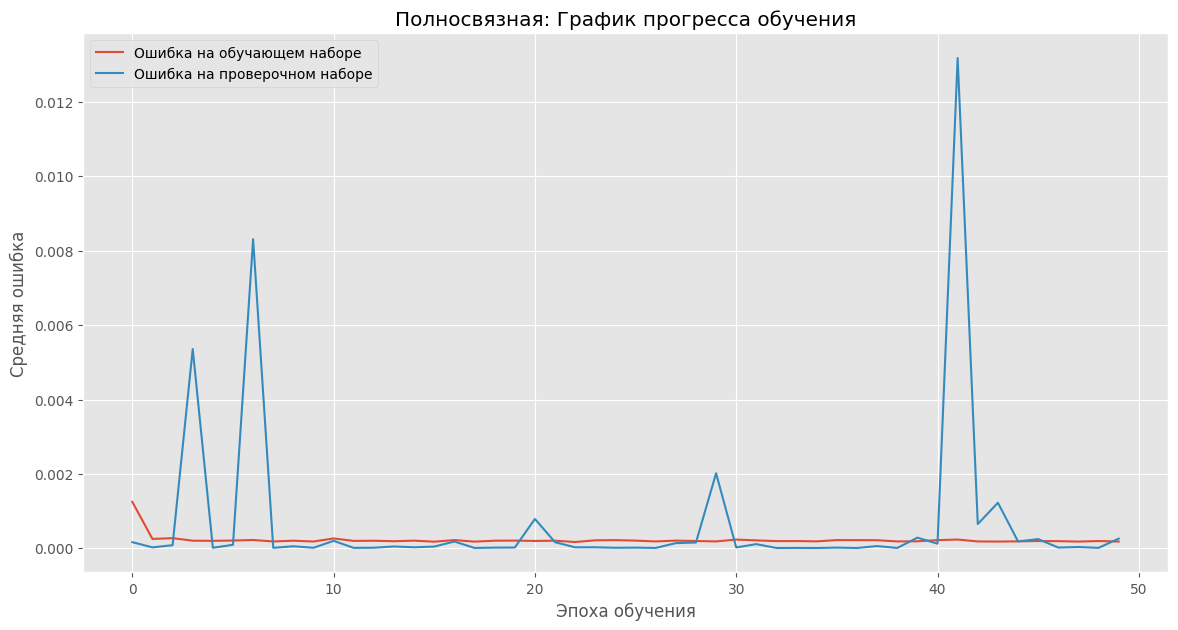

910/910 [==============================] - 5s 5ms/step


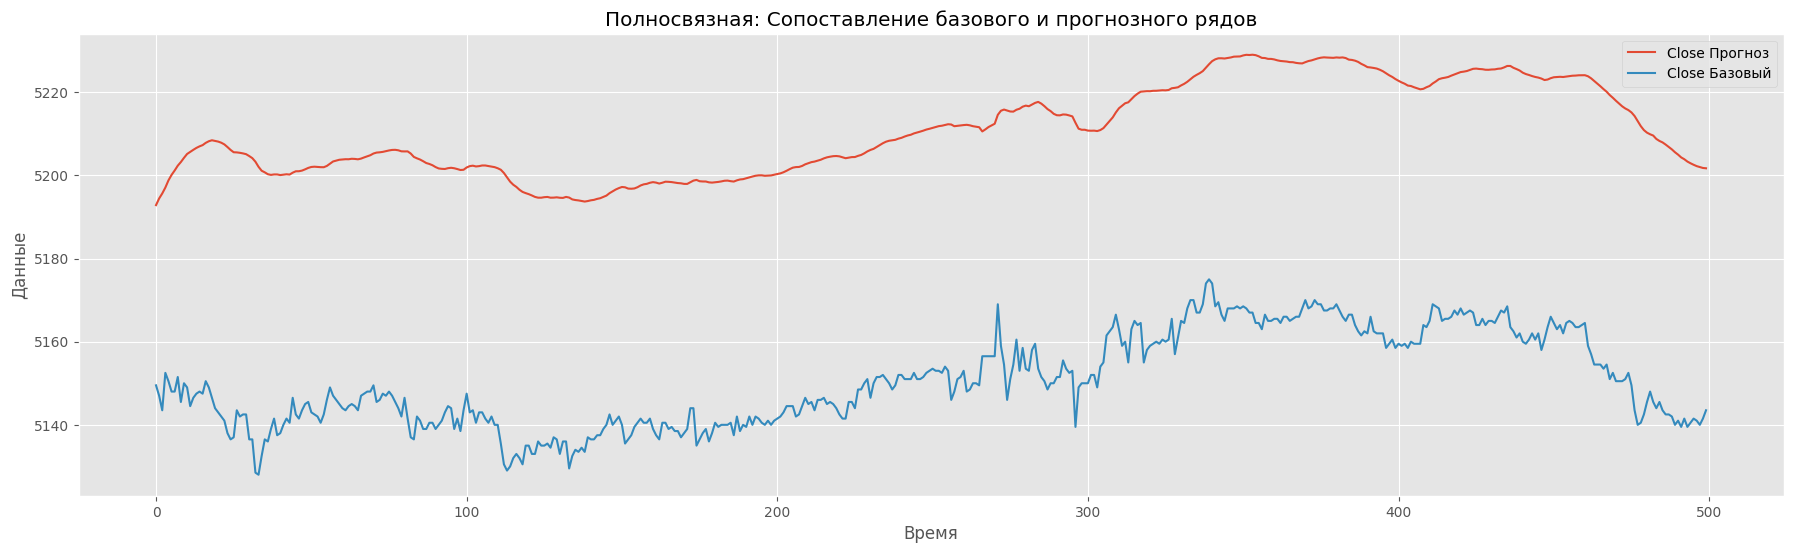

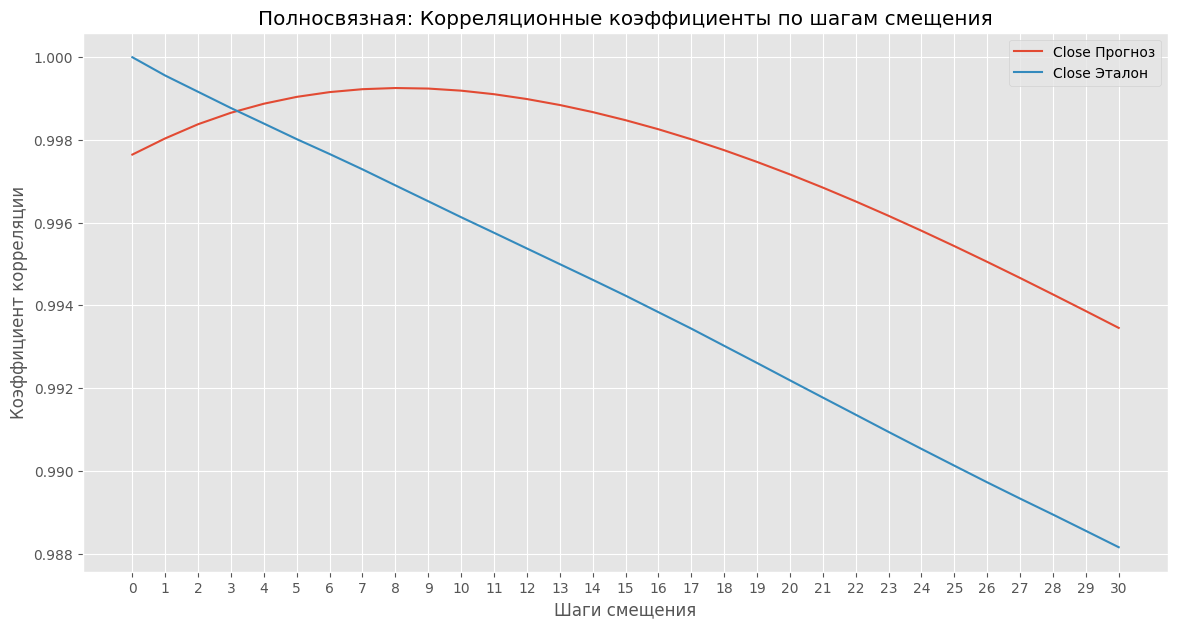

In [ ]:
# Простая полносвязная сеть
model_dense = Sequential()
model_dense.add(Dense(150, input_shape=x_test.shape[1:], activation='relu'))
model_dense.add(Flatten())
model_dense.add(Dense(y_test.shape[1], activation='linear'))

# Обучение модели 3x50 эпох
train_eval_net(model_dense, train_datagen_10step_straight, val_datagen_10step_straight, [(50, Adam(lr=1e-6))],
               x_test, y_test, y_scaler, title='Полносвязная')

910/910 [==============================] - 5s 5ms/step


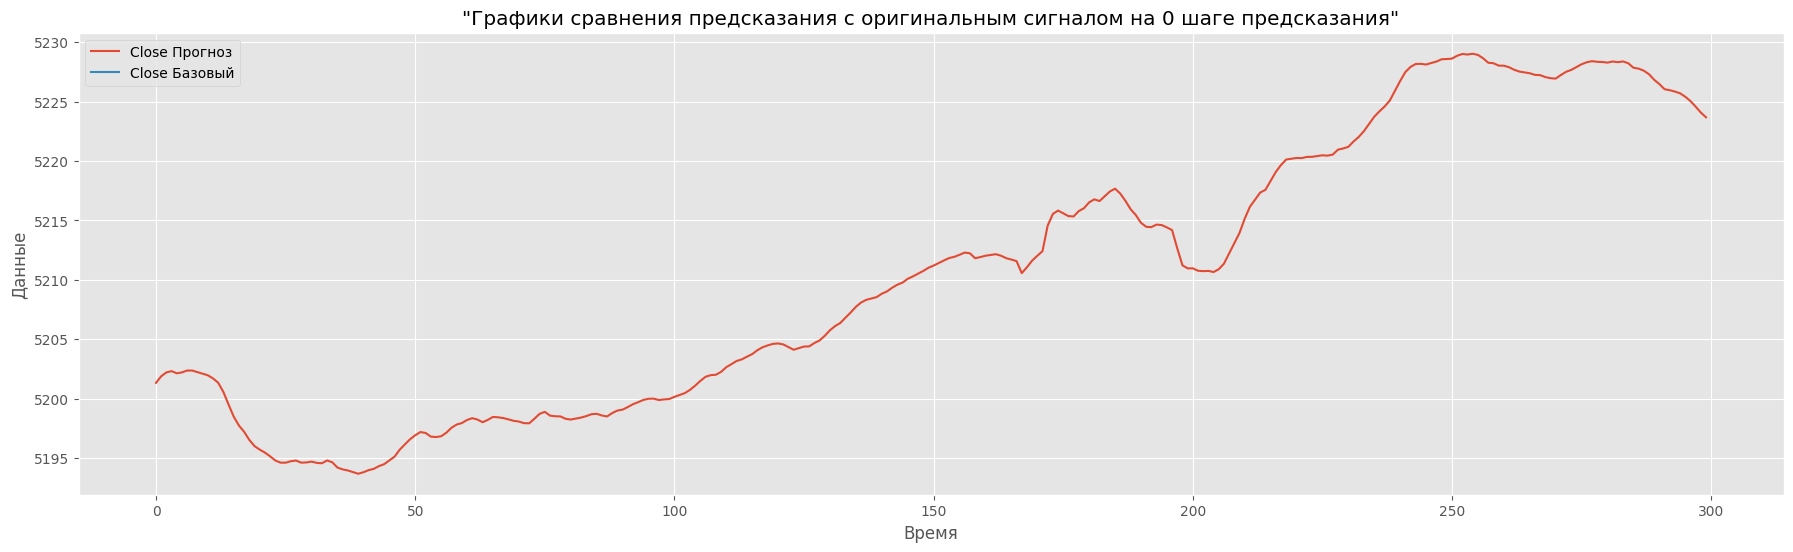

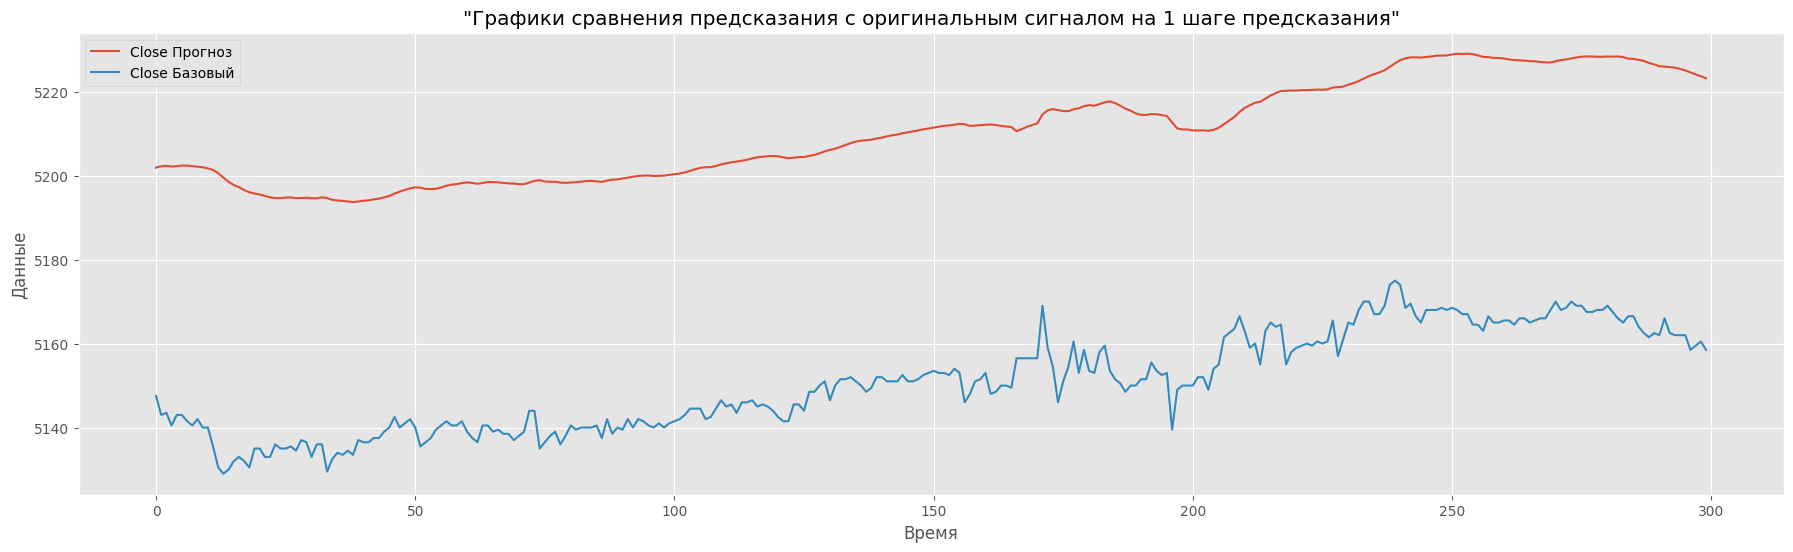

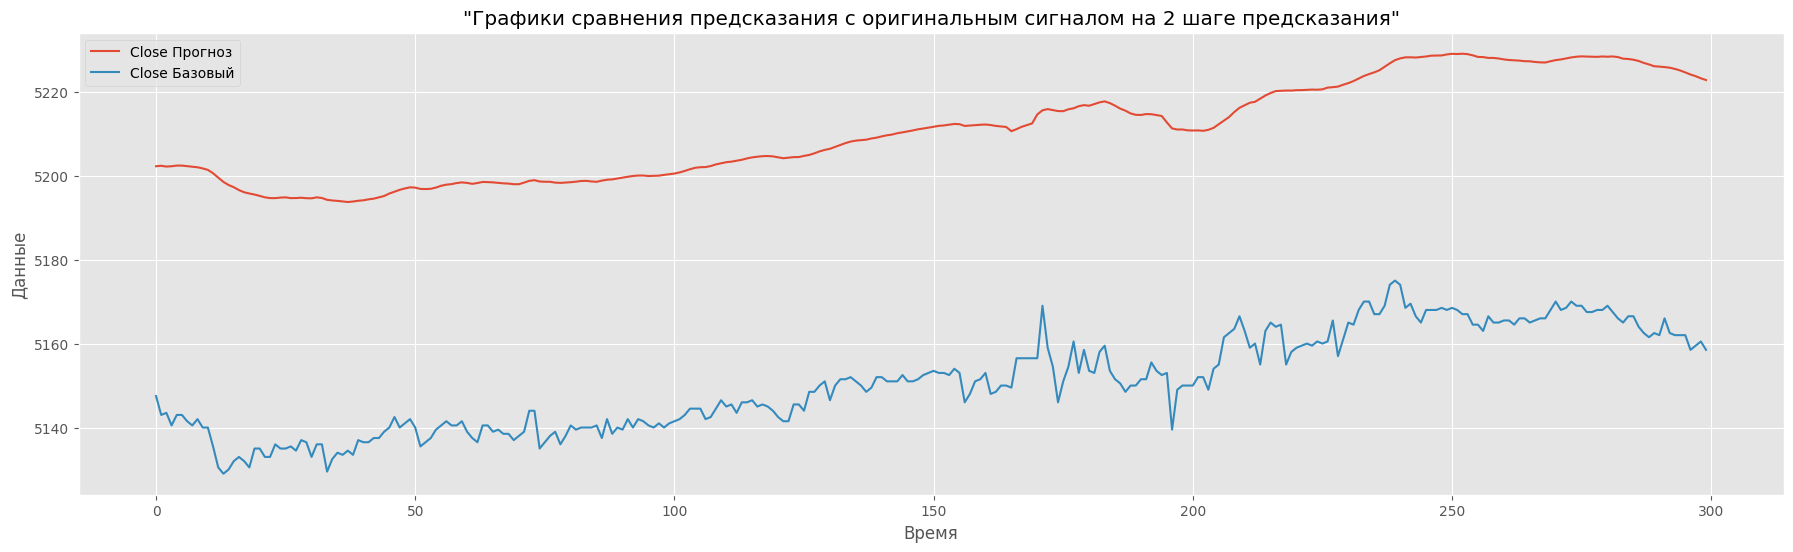

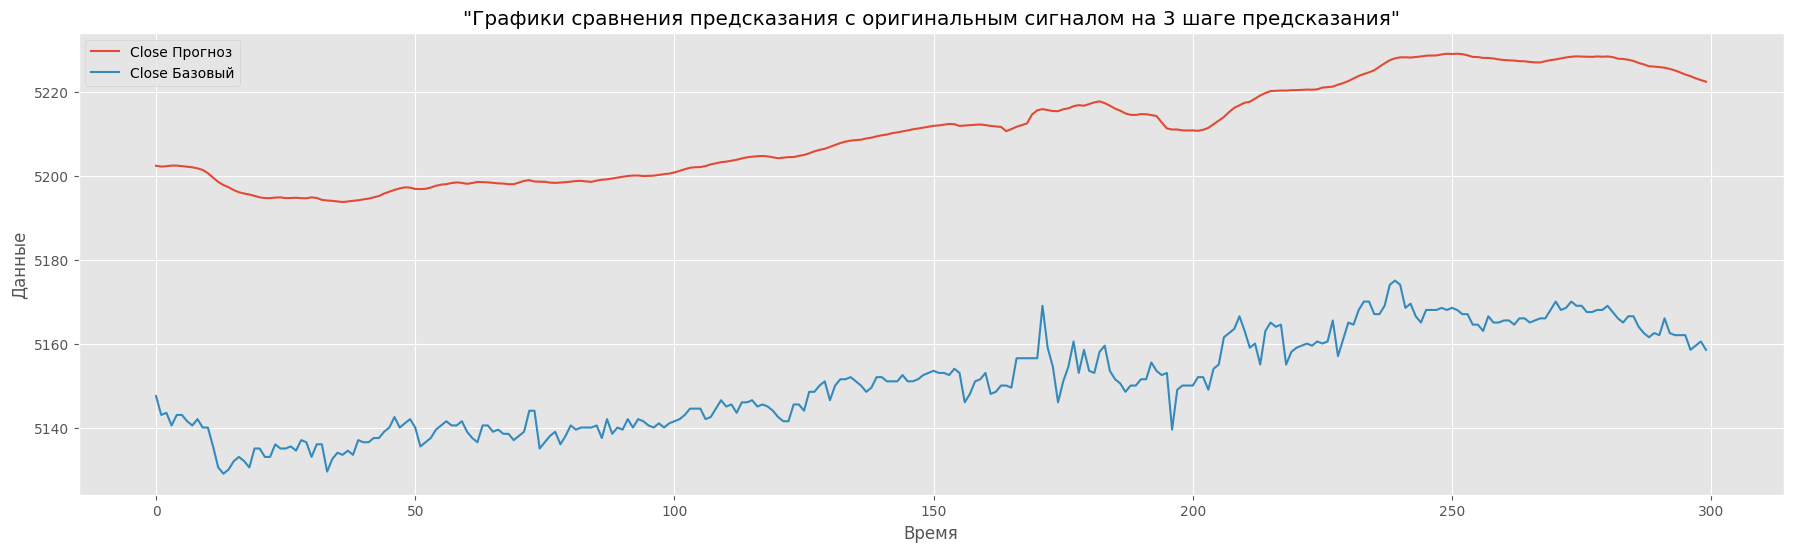

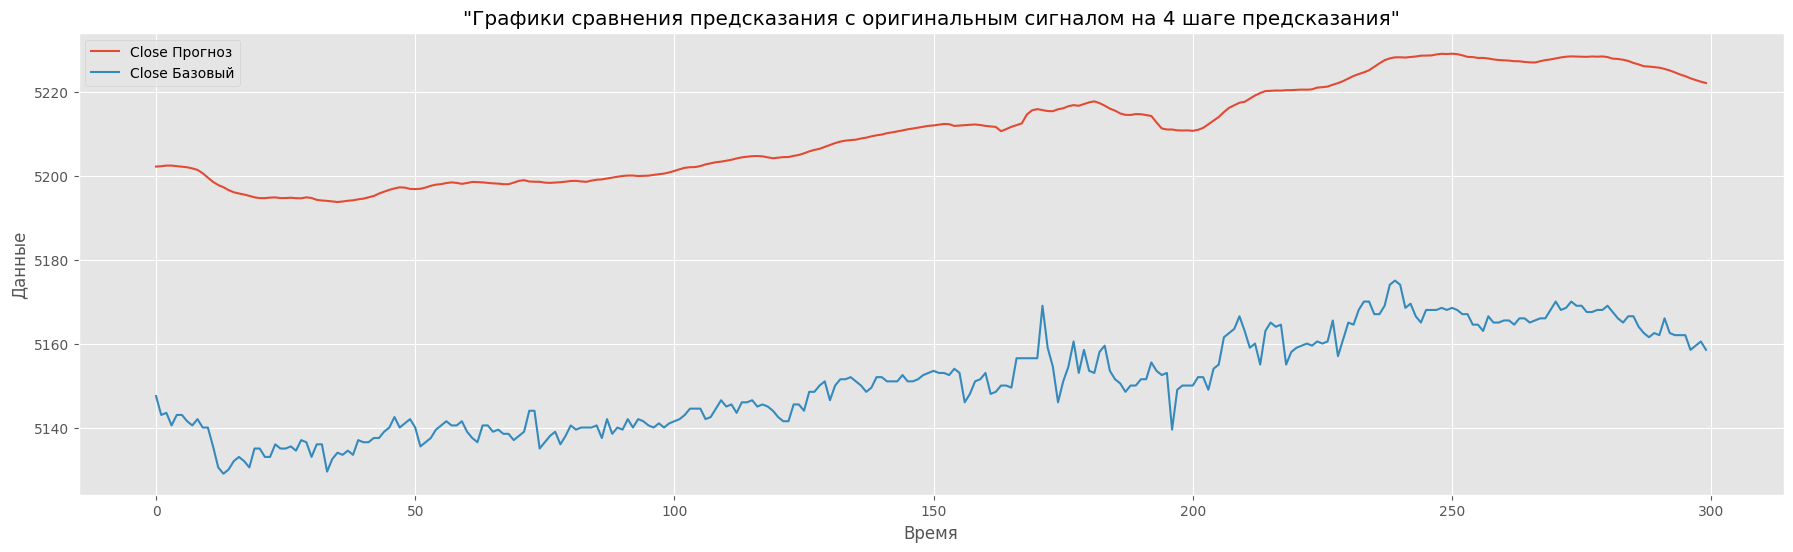

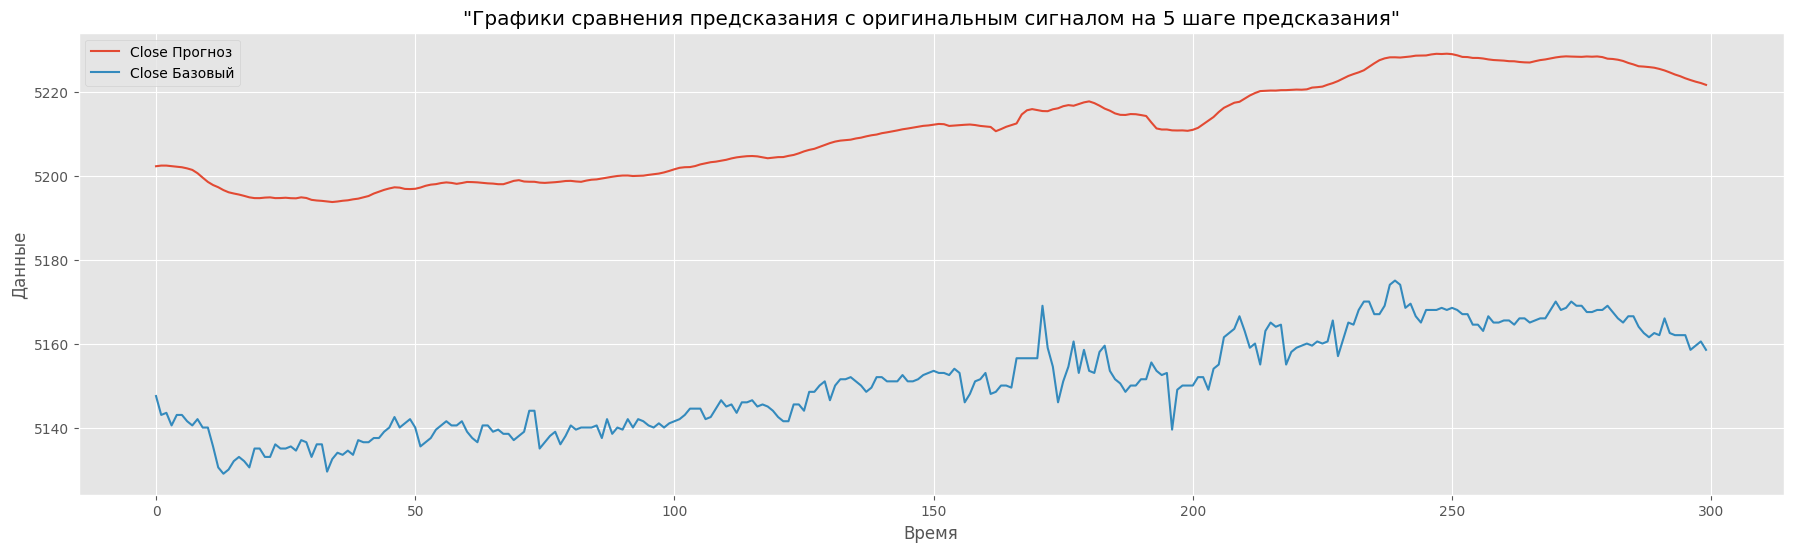

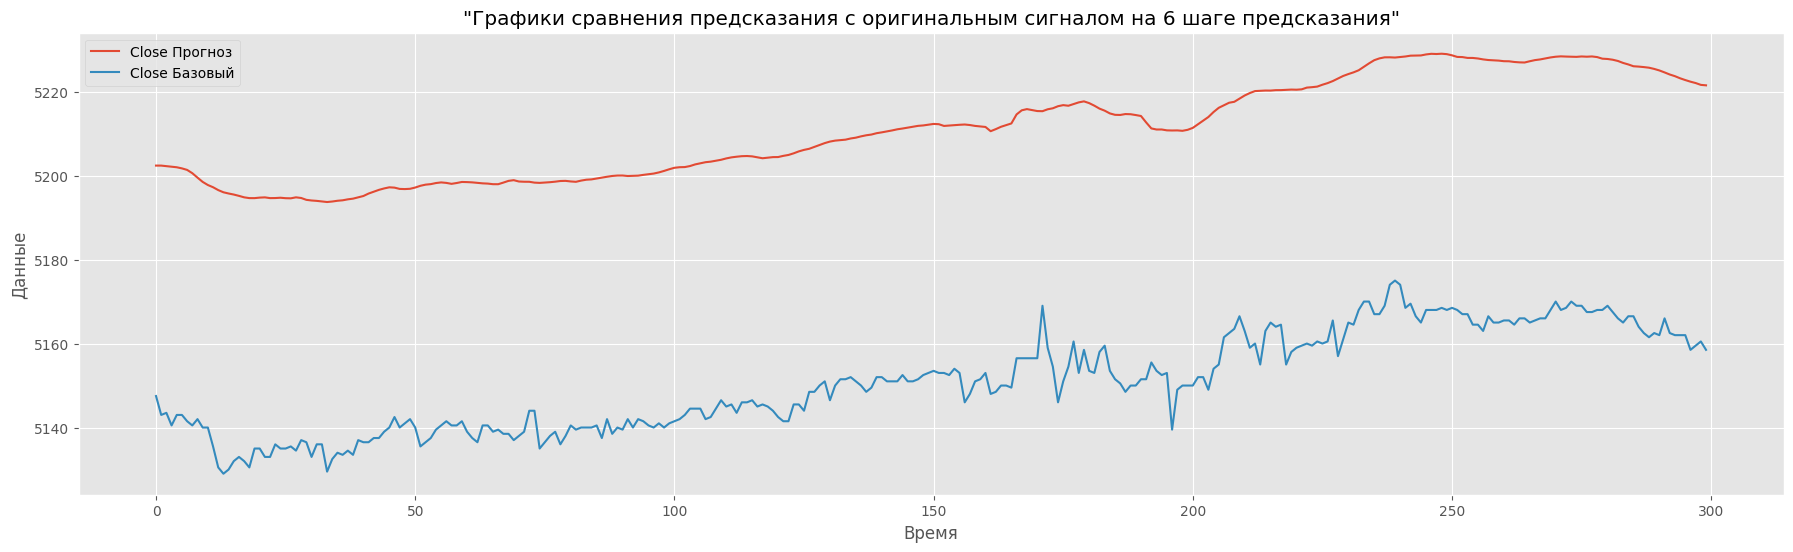

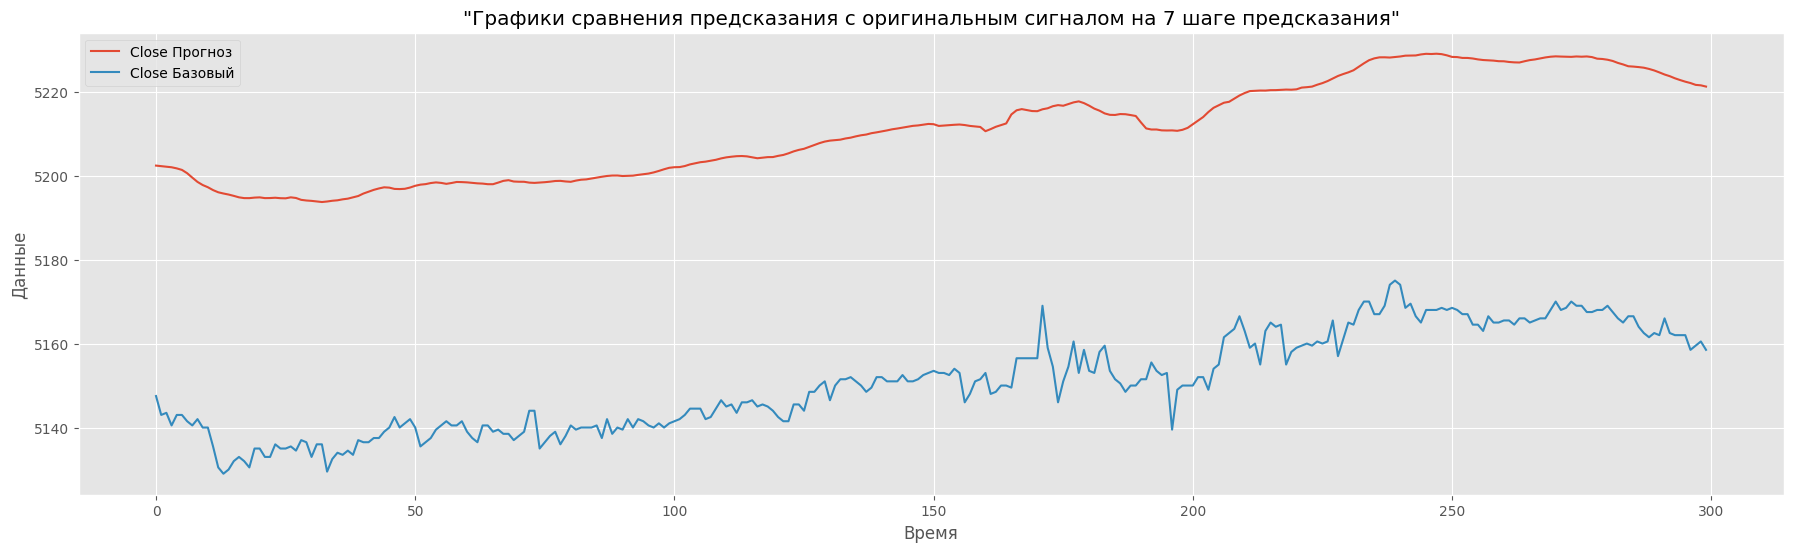

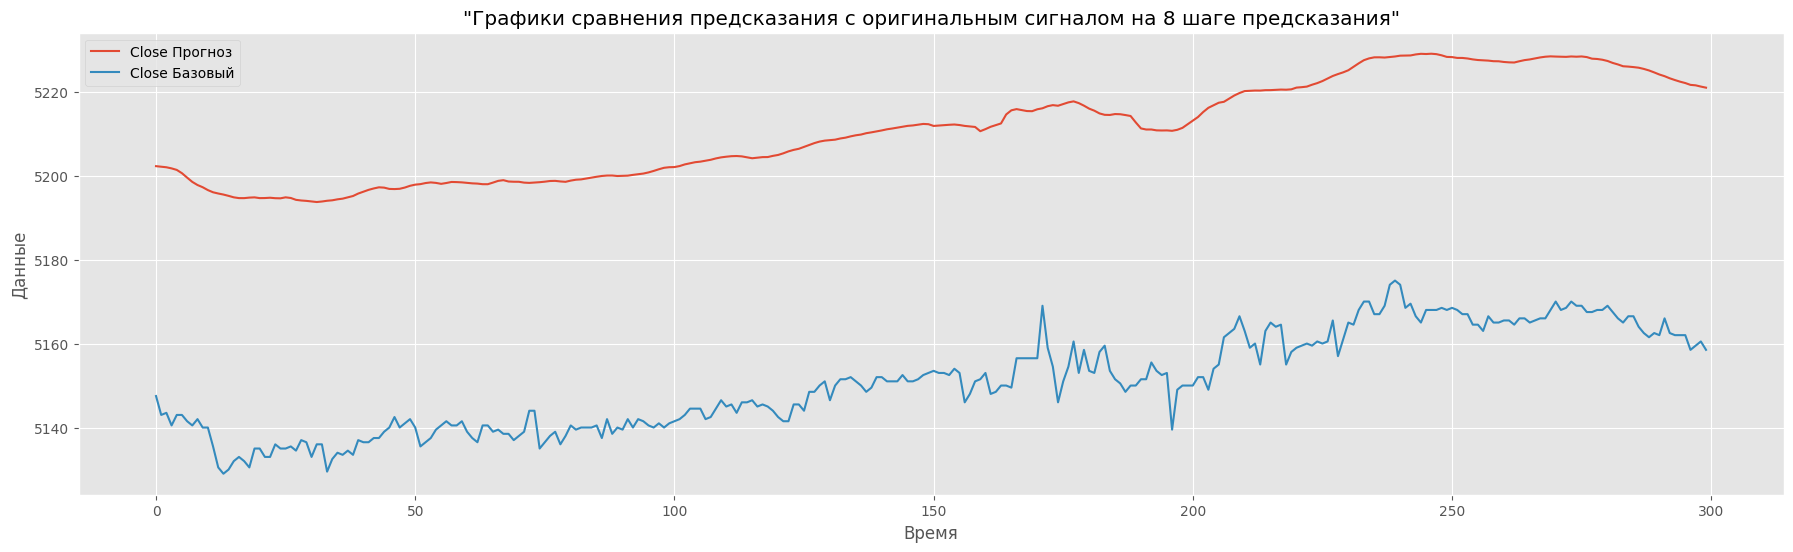

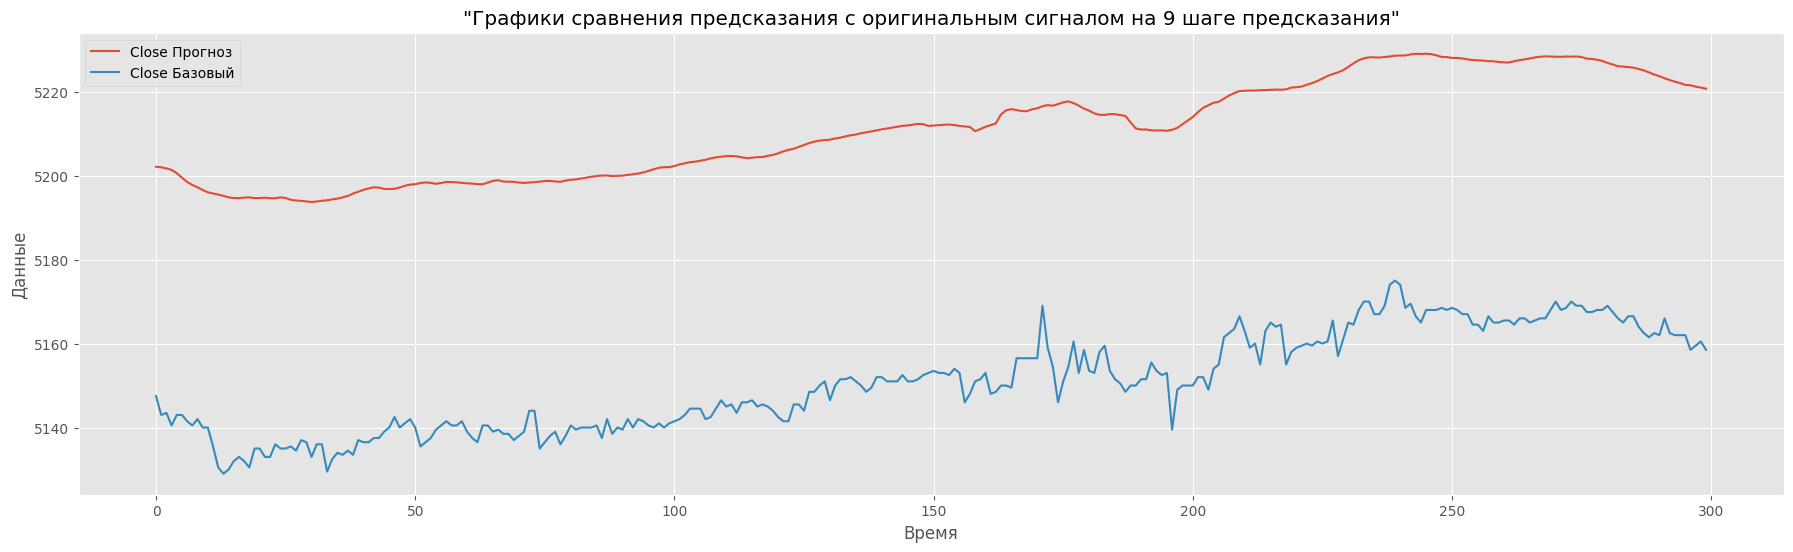

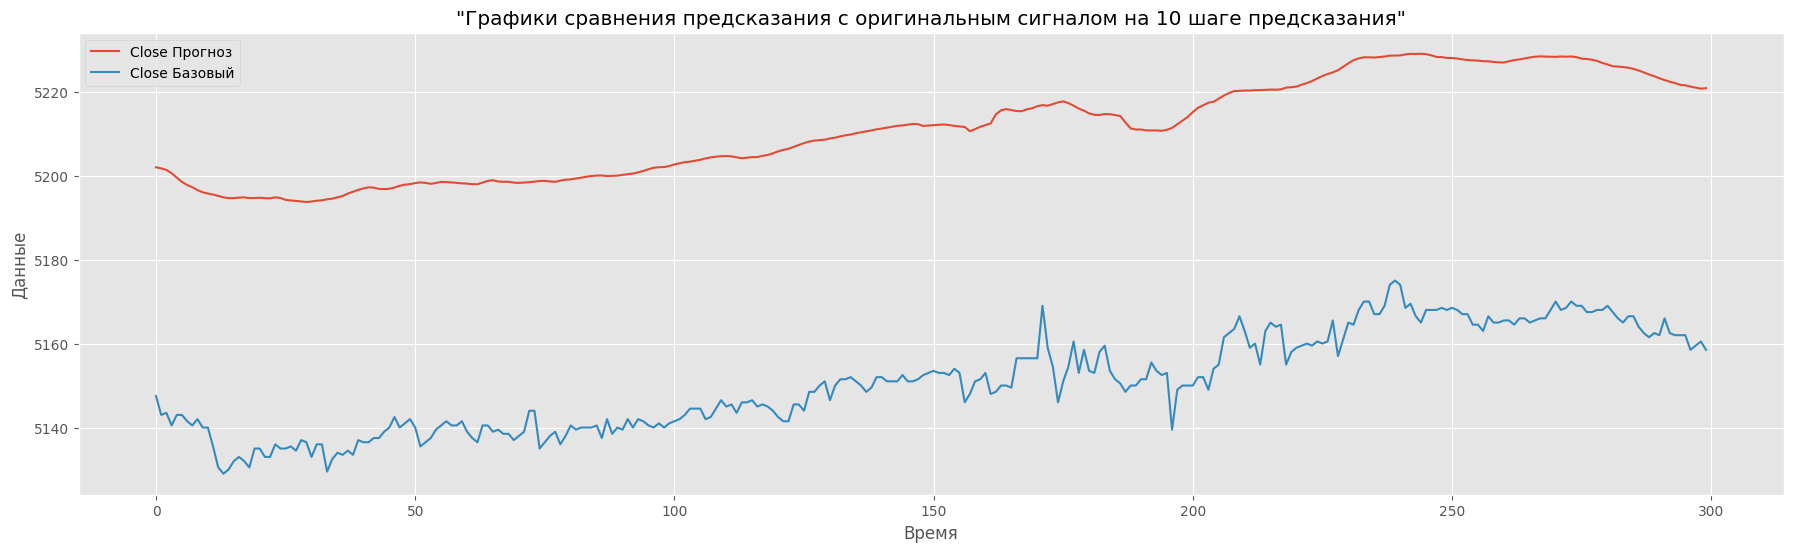

In [ ]:
y_pred = y_scaler.inverse_transform(model_dense.predict(x_test)) # Вычисление и деномализация предсказания
y_true = y_scaler.inverse_transform(y_test)                     # Денормализация верных ответов

for i in range(11):
  show_predict(y_pred[i:], y_true[:-i], start, length,                        # Отрисовка графика сопоставления базового и прогнозного рядов
              title=f'"Графики сравнения предсказания с оригинальным сигналом на {i} шаге предсказания"')

# Обучение нейронки с одномерной сверткой

Обучение 20 эпох
Epoch 1/20
22579/22579 [==============================] - 122s 5ms/step - loss: 7.3073e-04 - val_loss: 7.8626e-04
Epoch 2/20
22579/22579 [==============================] - 112s 5ms/step - loss: 1.3977e-04 - val_loss: 6.1953e-05
Epoch 3/20
22579/22579 [==============================] - 110s 5ms/step - loss: 1.1593e-04 - val_loss: 1.2452e-04
Epoch 4/20
22579/22579 [==============================] - 109s 5ms/step - loss: 1.0813e-04 - val_loss: 6.7839e-04
Epoch 5/20
22579/22579 [==============================] - 109s 5ms/step - loss: 1.1333e-04 - val_loss: 3.3339e-05
Epoch 6/20
22579/22579 [==============================] - 108s 5ms/step - loss: 9.6950e-05 - val_loss: 2.2601e-05
Epoch 7/20
22579/22579 [==============================] - 109s 5ms/step - loss: 9.1137e-05 - val_loss: 1.4818e-04
Epoch 8/20
22579/22579 [==============================] - 123s 5ms/step - loss: 1.2802e-04 - val_loss: 2.3801e-05
Epoch 9/20
22579/22579 [==============================] - 116s 5ms/step

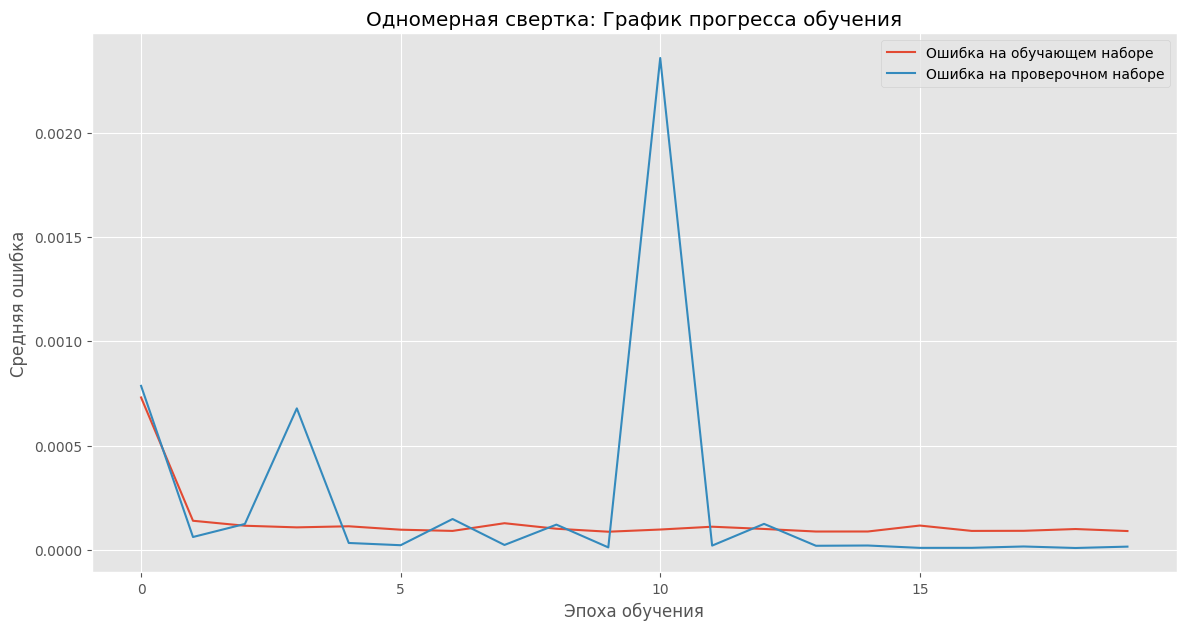

910/910 [==============================] - 2s 2ms/step


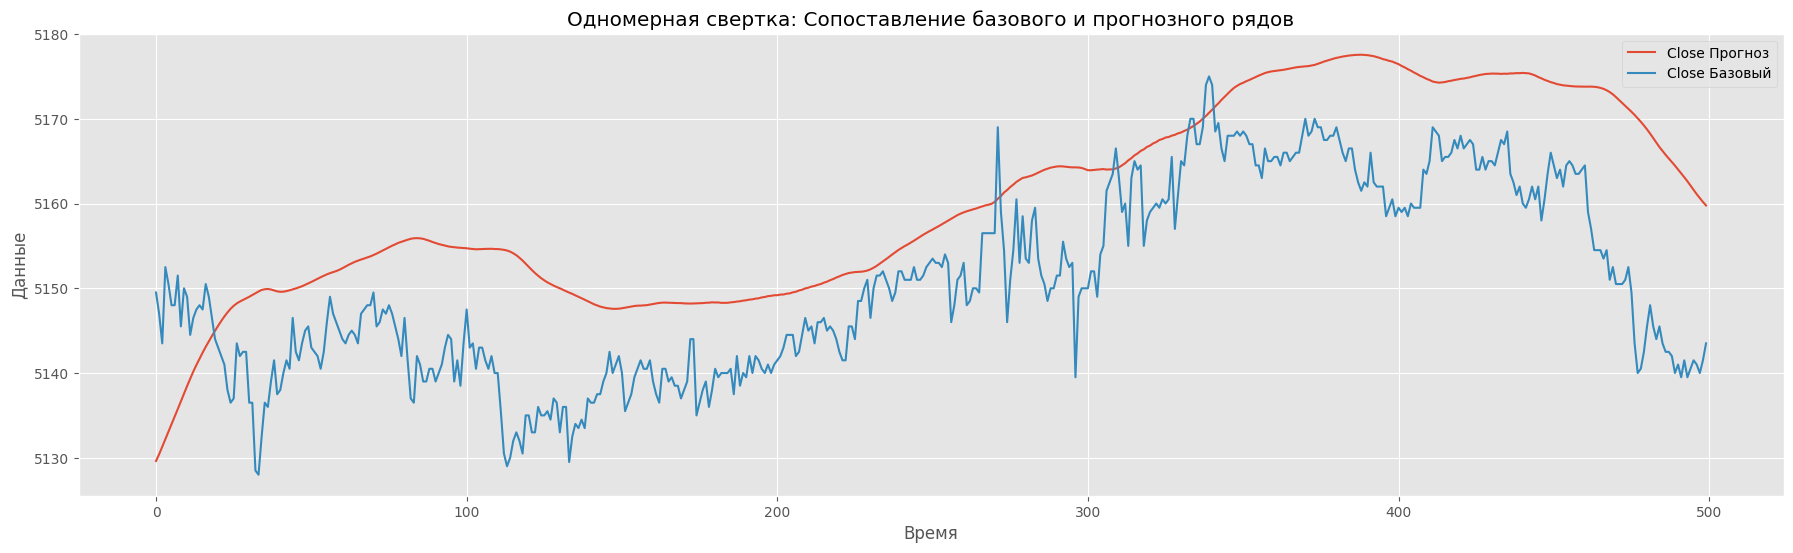

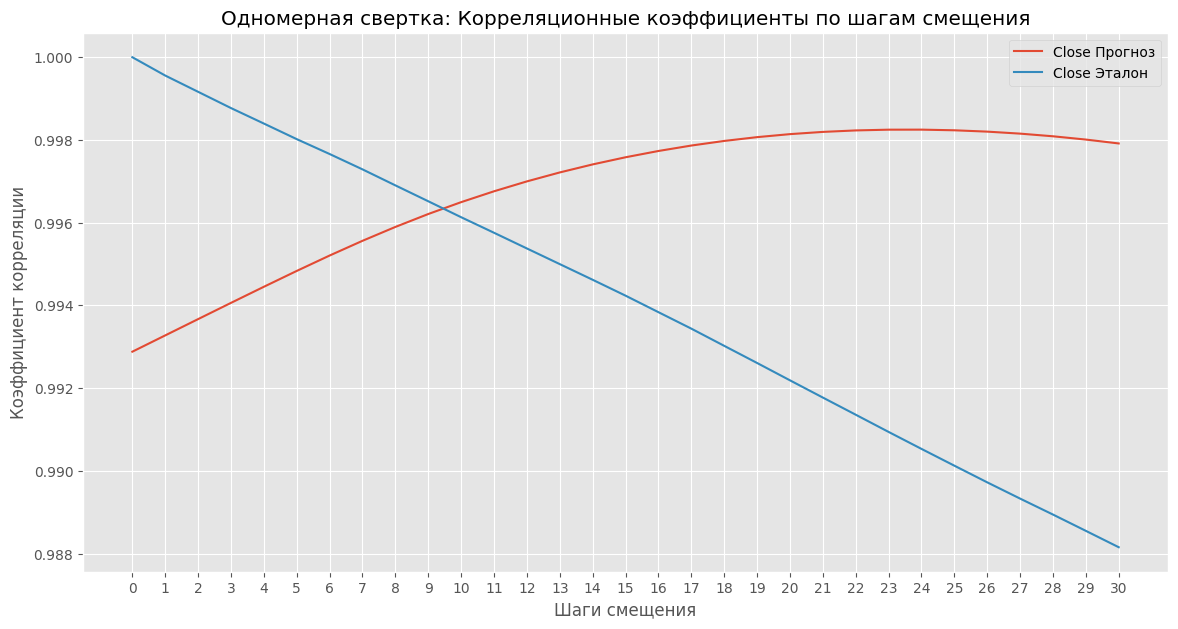

In [ ]:
# Модель с одномерной сверткой
model_conv = Sequential()
model_conv.add(Conv1D(64, 5, input_shape=x_test.shape[1:], activation='relu'))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D())
model_conv.add(Flatten())
model_conv.add(Dense(100, activation='relu'))
model_conv.add(Dense(y_test.shape[1], activation='linear'))


# Обучение модели 50+20 эпох
train_eval_net(model_conv, train_datagen, val_datagen, [(20, Adam(lr=1e-4))],
               x_test, y_test, y_scaler, title='Одномерная свертка')

In [ ]:
train_datagen.data.shape

(451872, 5)

910/910 [==============================] - 2s 2ms/step


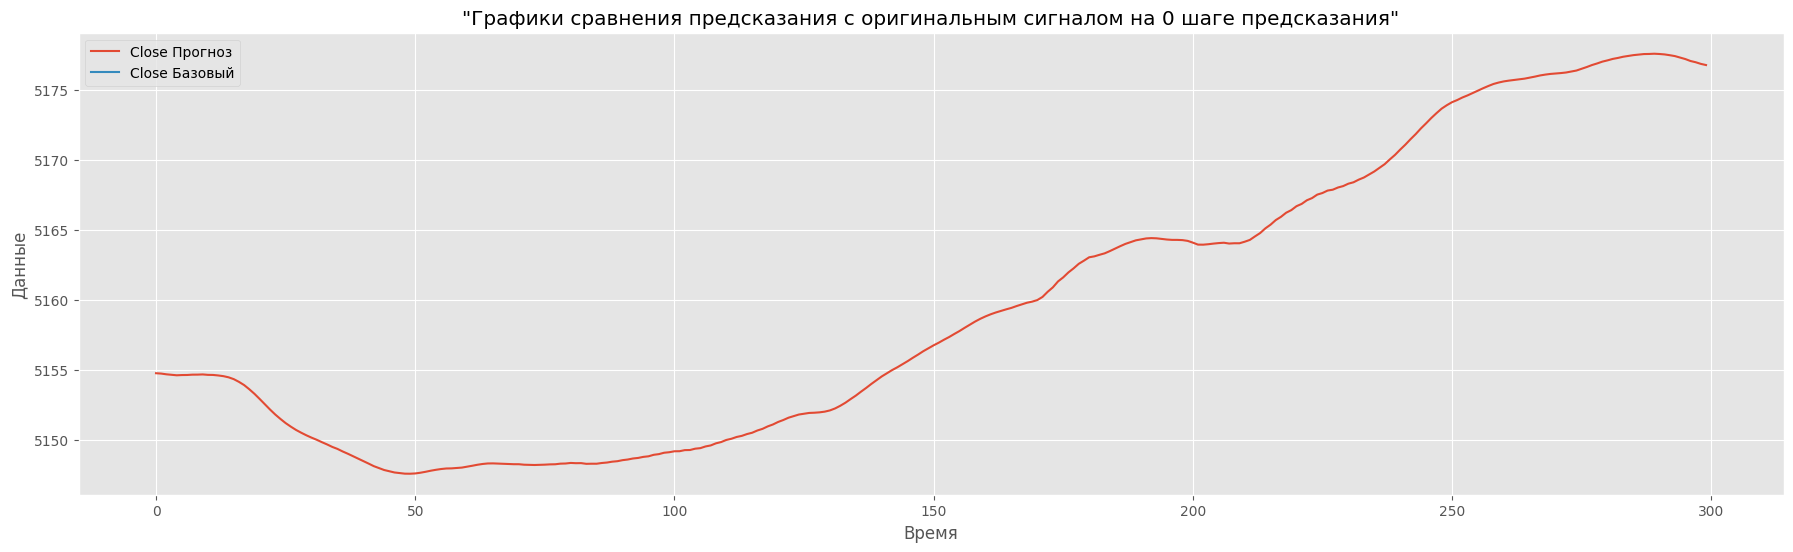

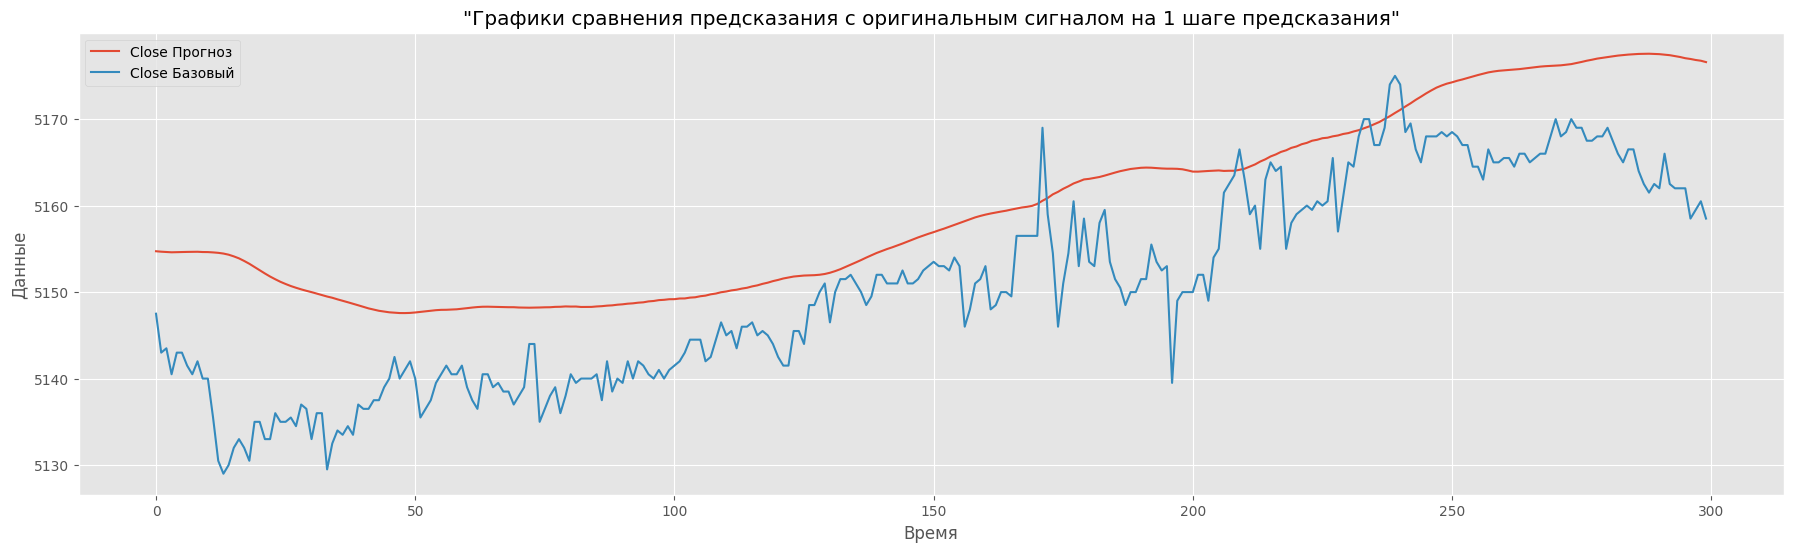

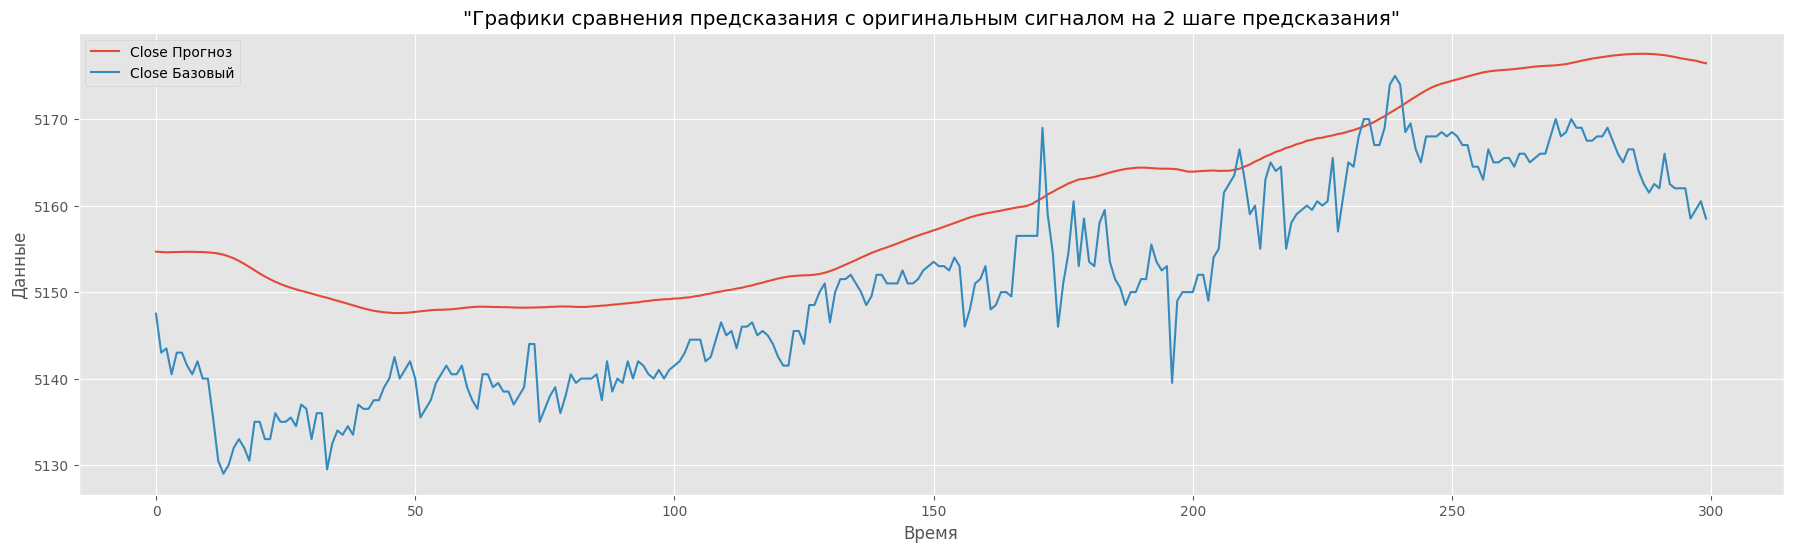

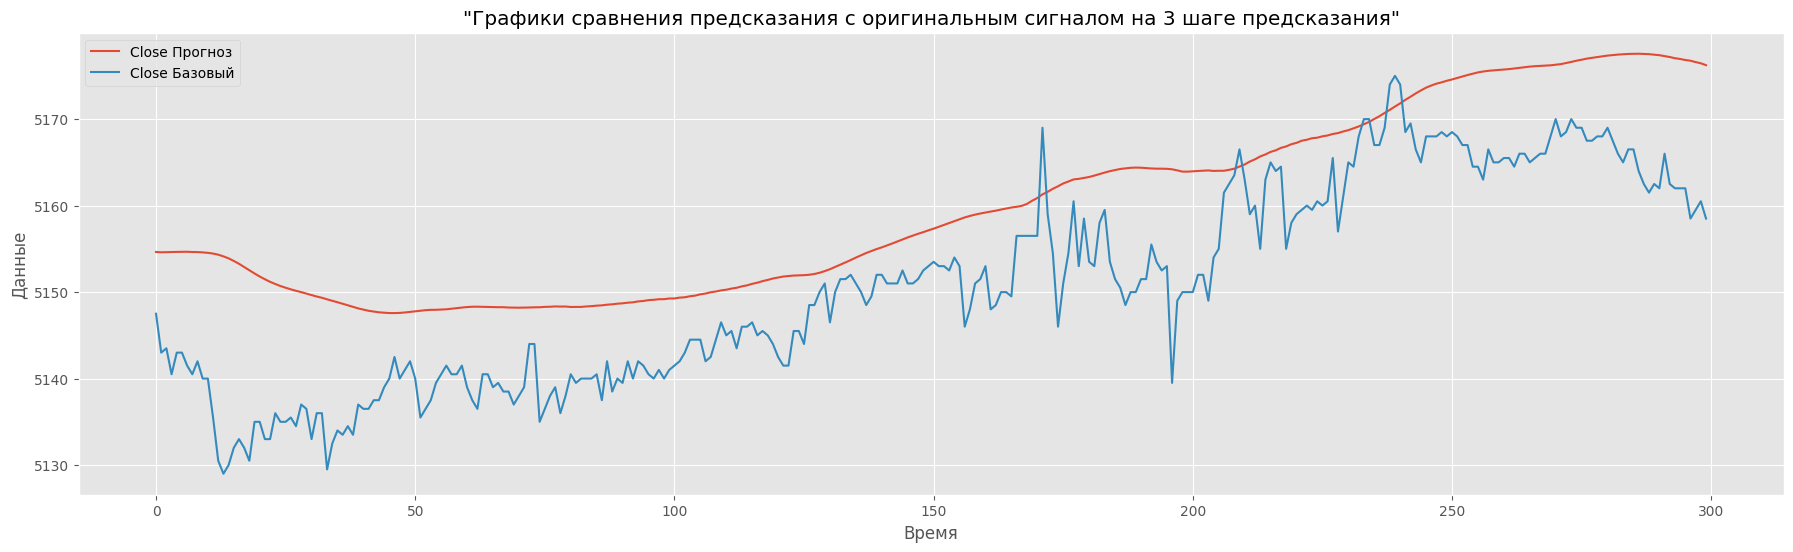

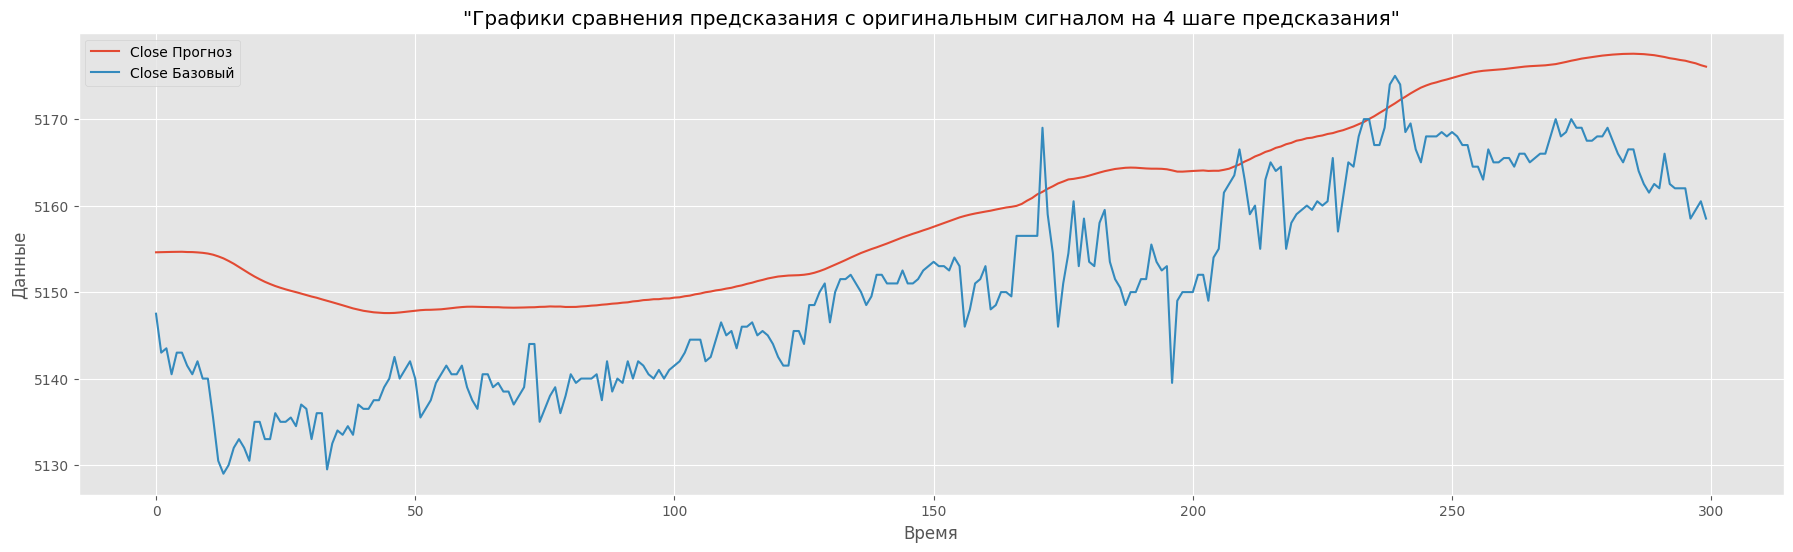

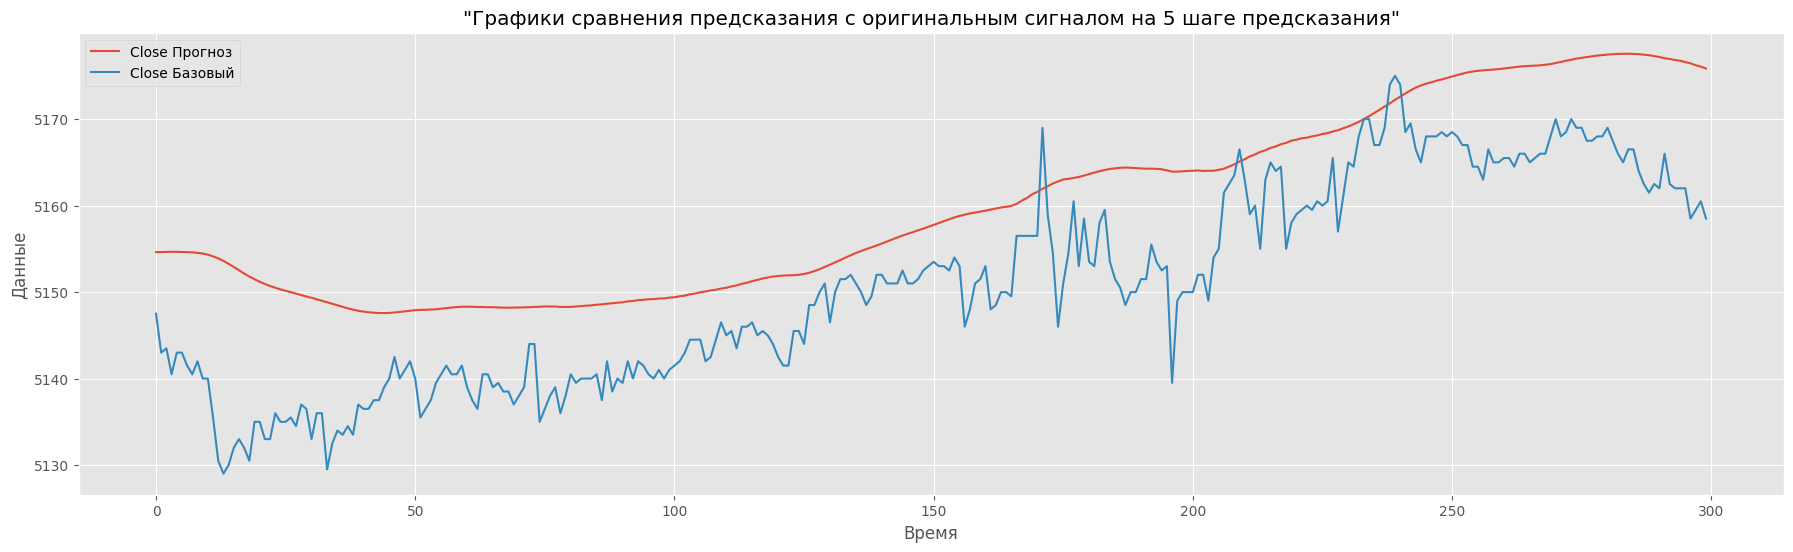

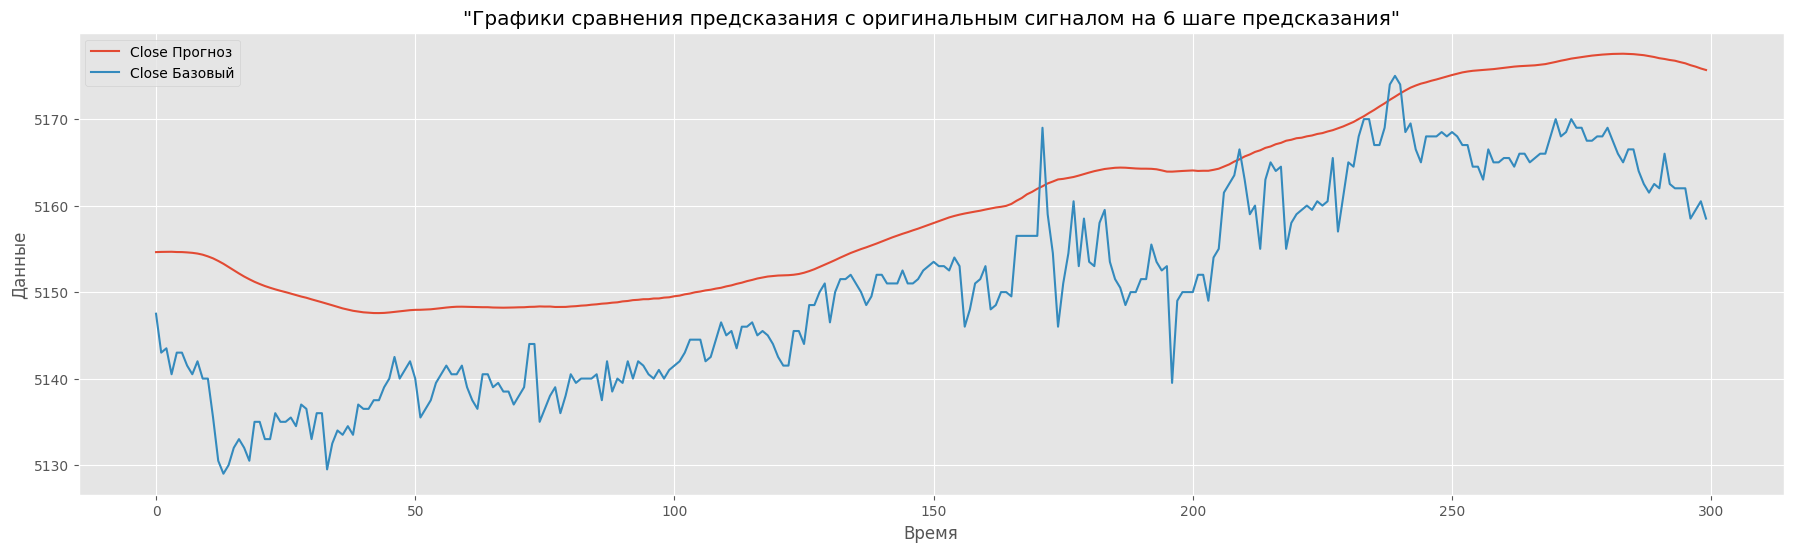

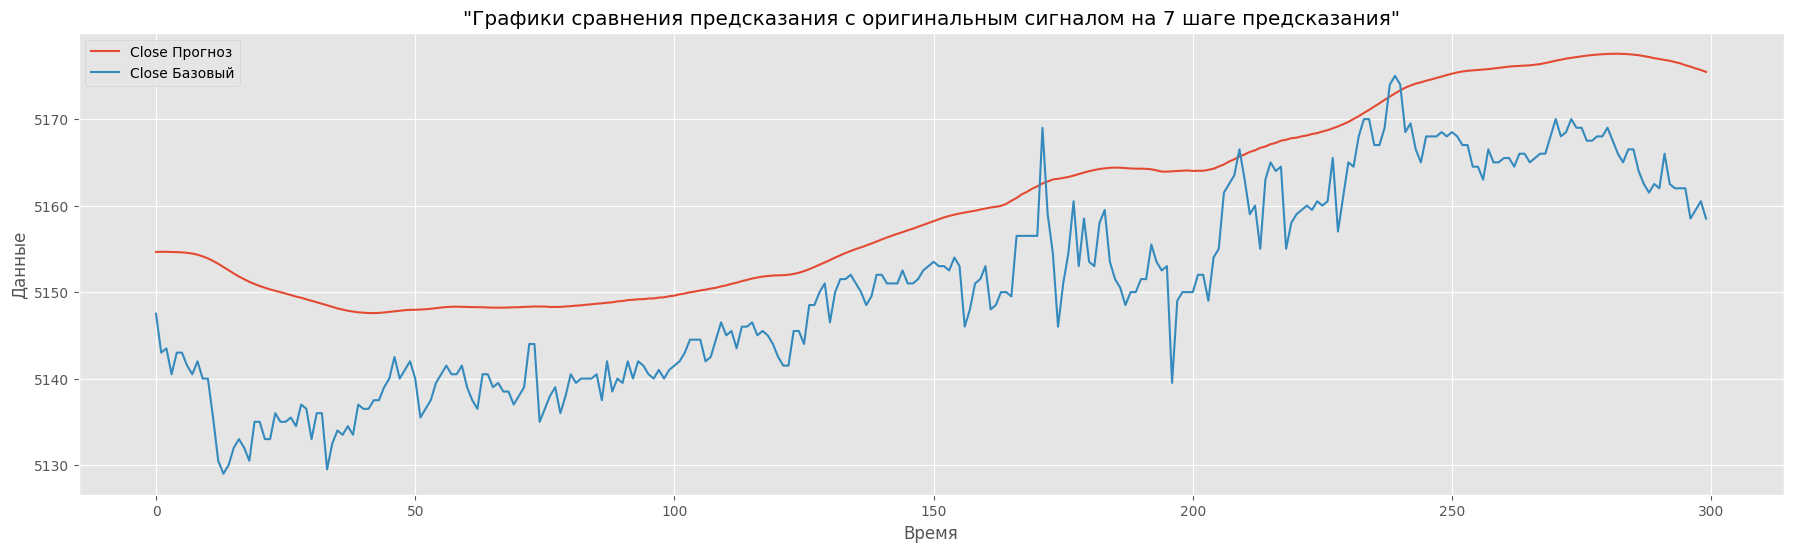

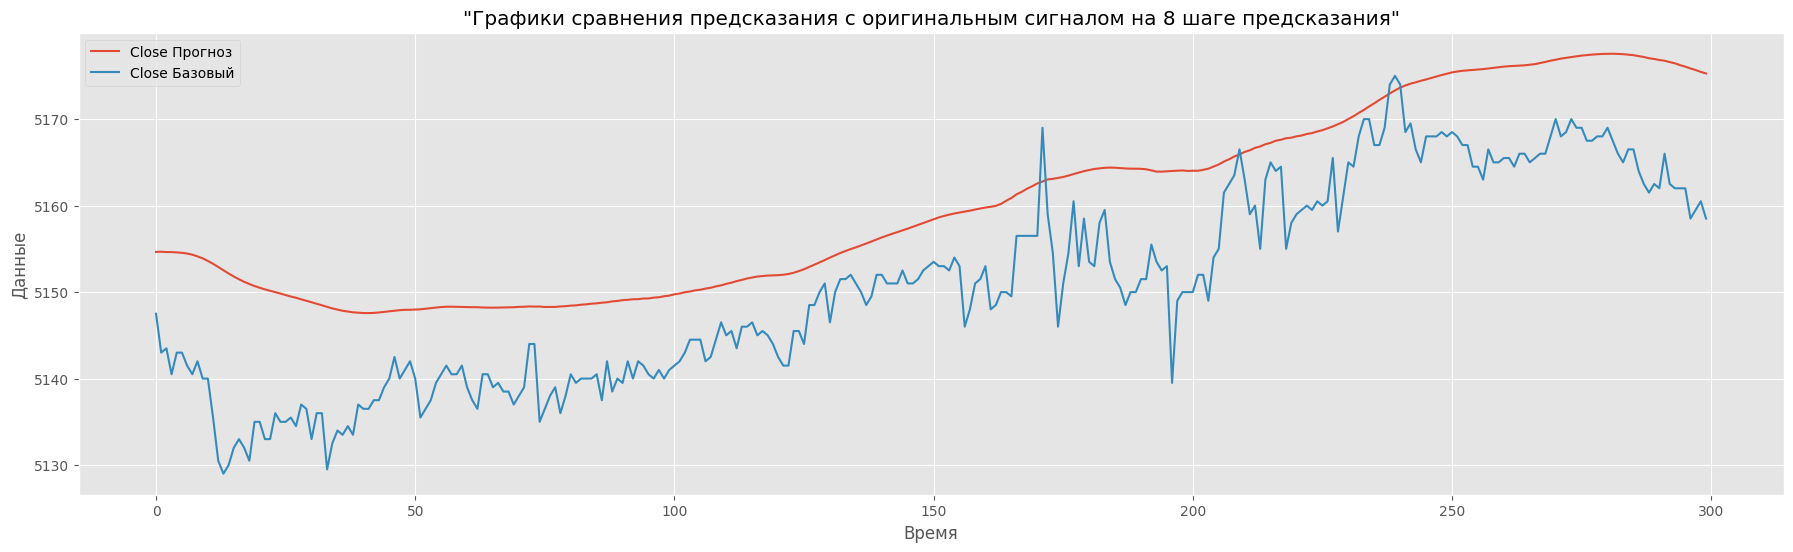

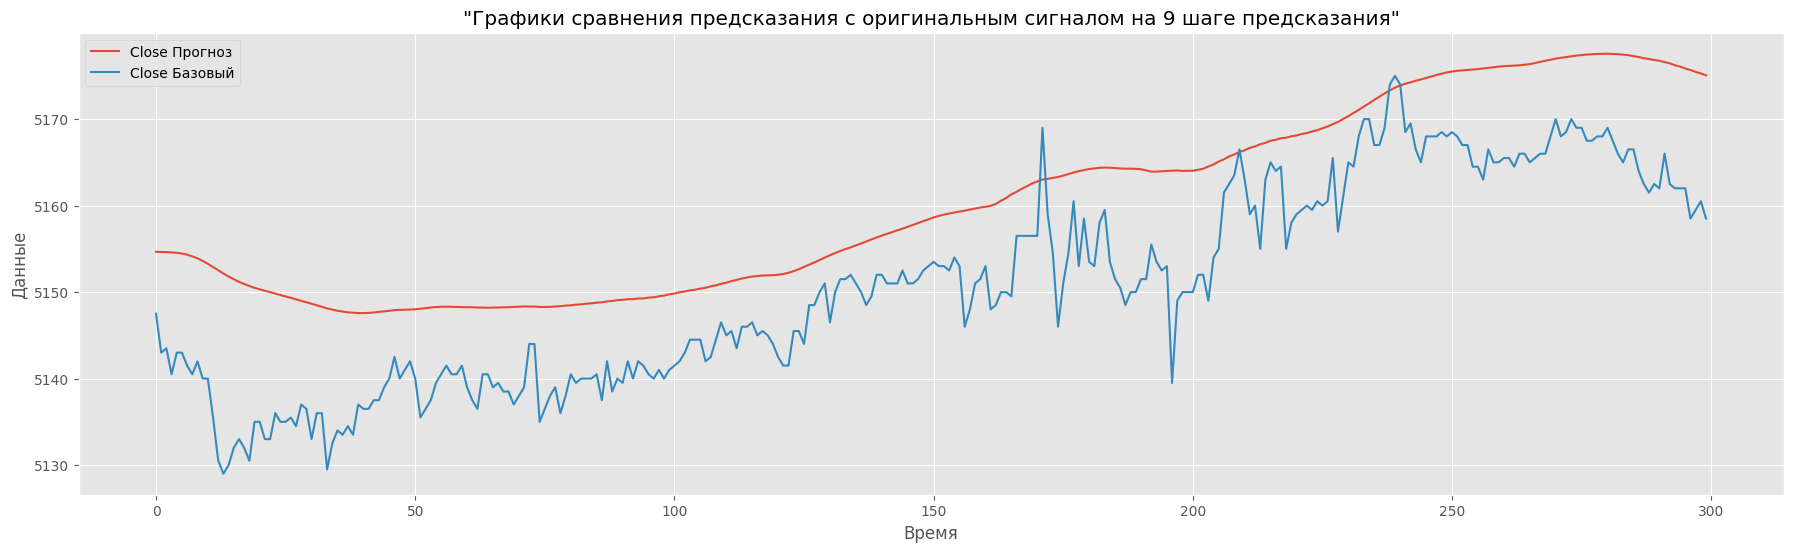

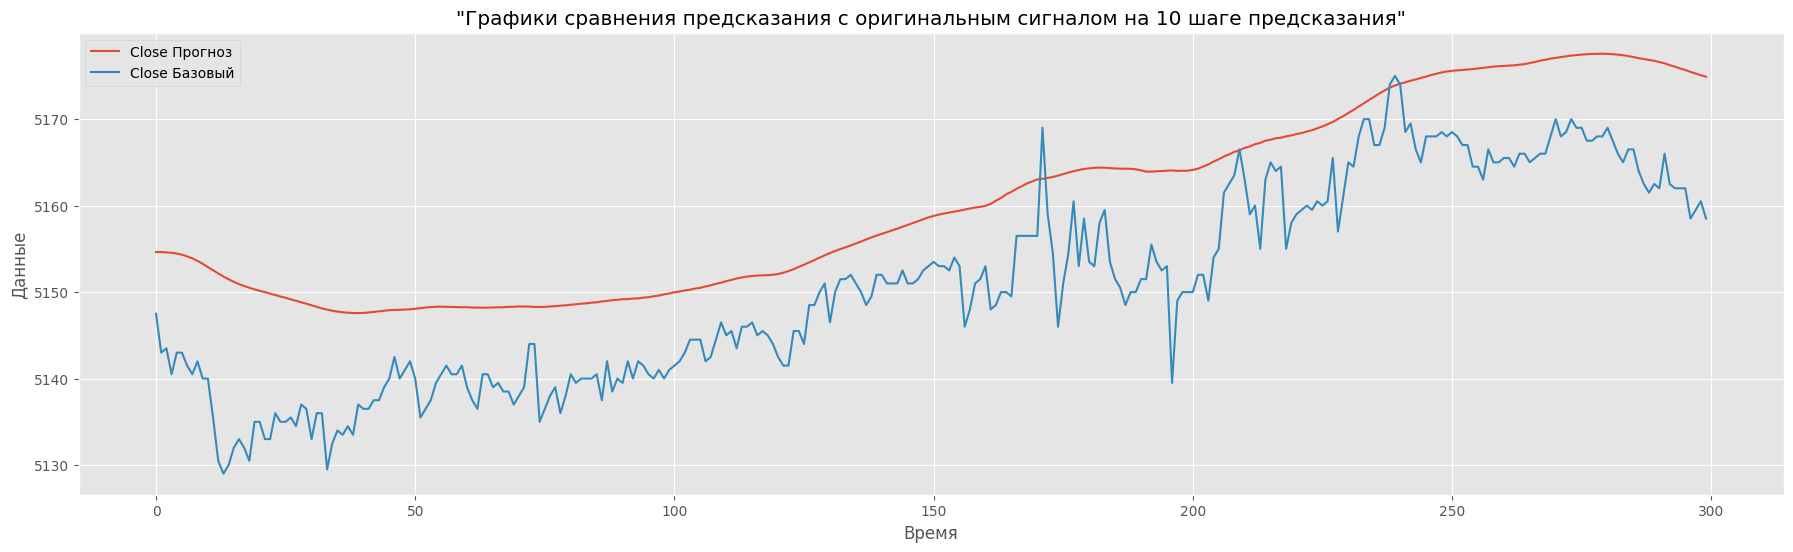

In [ ]:
y_pred = y_scaler.inverse_transform(model_conv.predict(x_test)) # Вычисление и деномализация предсказания
y_true = y_scaler.inverse_transform(y_test)                     # Денормализация верных ответов

for i in range(11):
  show_predict(y_pred[i:], y_true[:-i], start, length,                        # Отрисовка графика сопоставления базового и прогнозного рядов
              title=f'"Графики сравнения предсказания с оригинальным сигналом на {i} шаге предсказания"')

# Обучение с рекуррентной сетью (LSTM)

Обучение 20 эпох
Epoch 1/20
22579/22579 [==============================] - 302s 13ms/step - loss: 2.7654e-04 - val_loss: 3.7981e-06
Epoch 2/20
22579/22579 [==============================] - 283s 13ms/step - loss: 1.2918e-05 - val_loss: 1.0456e-06
Epoch 3/20
22579/22579 [==============================] - 287s 13ms/step - loss: 1.0147e-05 - val_loss: 1.1692e-06
Epoch 4/20
22579/22579 [==============================] - 282s 12ms/step - loss: 8.4478e-06 - val_loss: 1.5547e-06
Epoch 5/20
22579/22579 [==============================] - 278s 12ms/step - loss: 7.8893e-06 - val_loss: 9.4033e-06
Epoch 6/20
22579/22579 [==============================] - 284s 13ms/step - loss: 5.6997e-06 - val_loss: 7.4661e-07
Epoch 7/20
22579/22579 [==============================] - 279s 12ms/step - loss: 5.9916e-06 - val_loss: 1.8802e-05
Epoch 8/20
22579/22579 [==============================] - 277s 12ms/step - loss: 5.1418e-06 - val_loss: 7.2922e-07
Epoch 9/20
22579/22579 [==============================] - 273s 

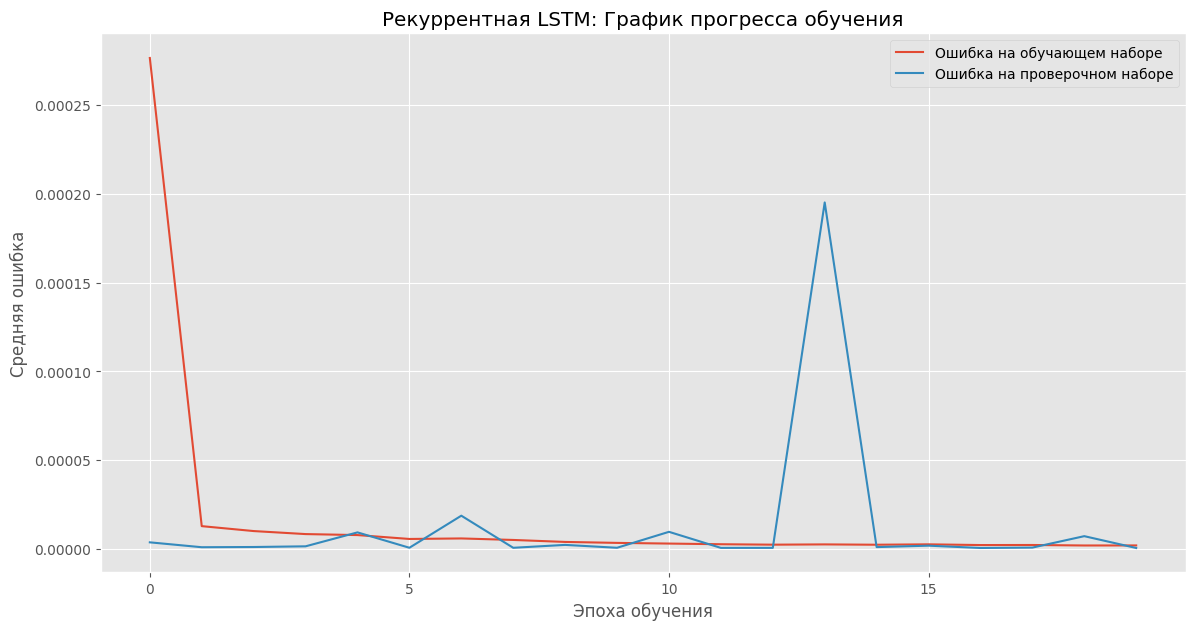

910/910 [==============================] - 5s 5ms/step


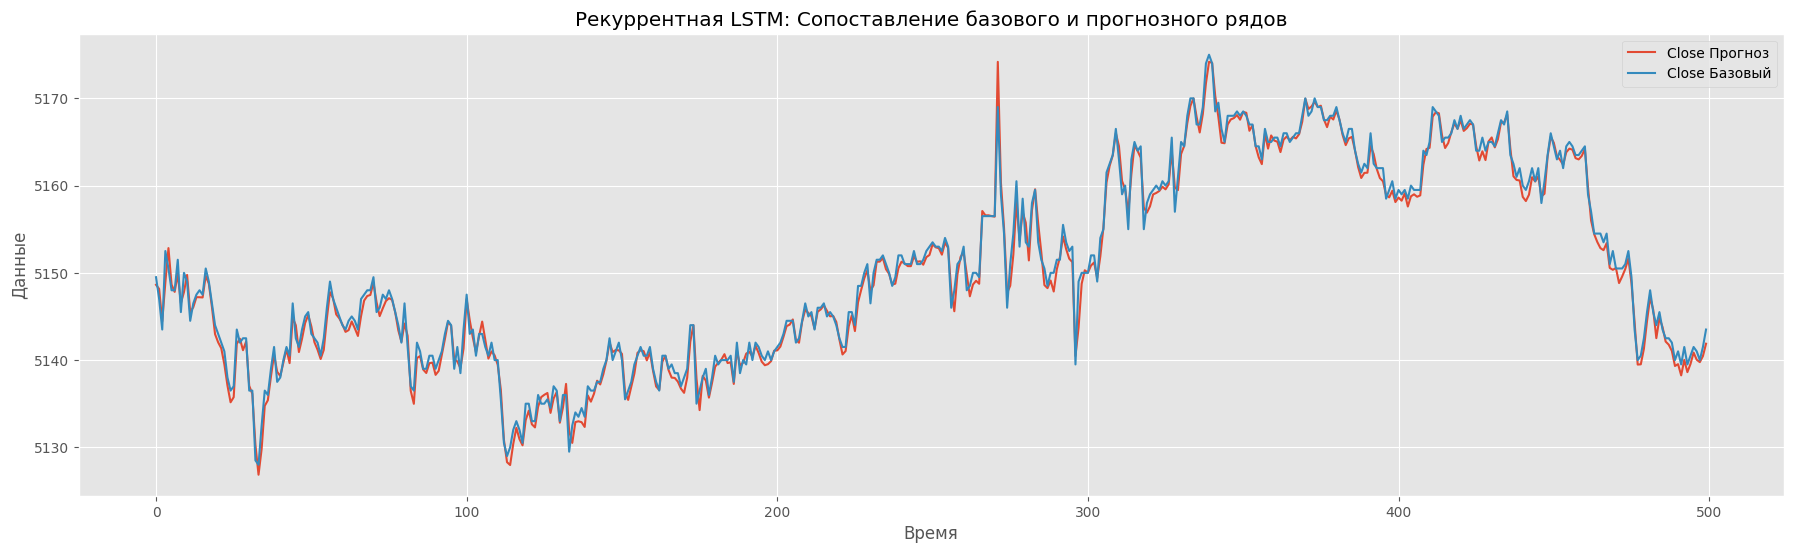

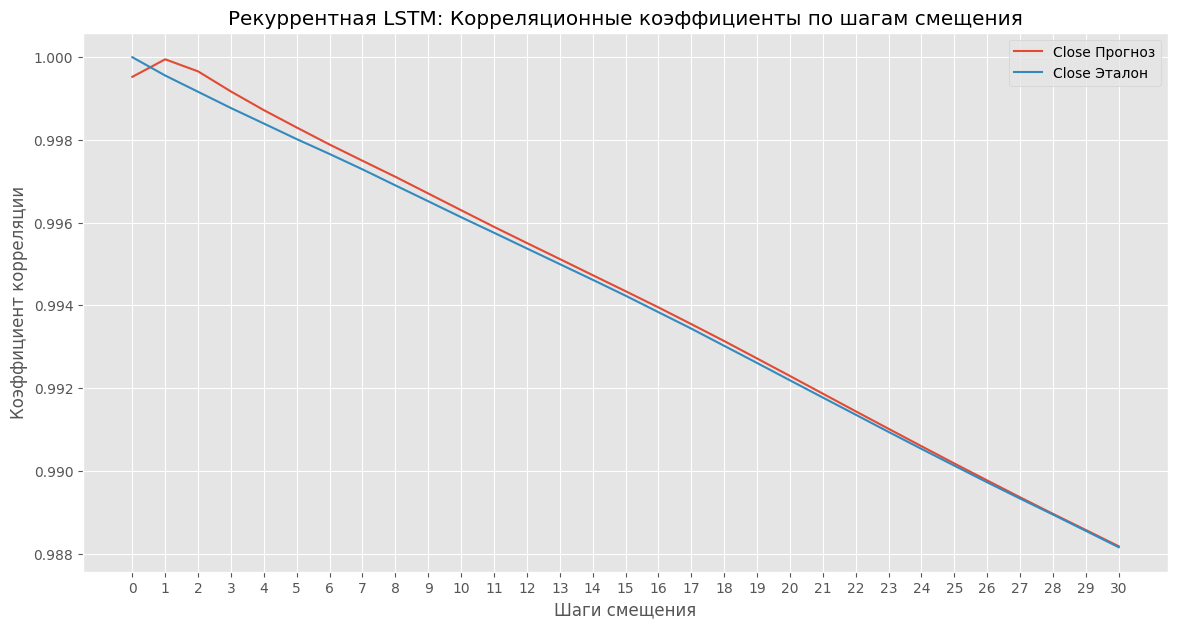

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(5, input_shape=x_test.shape[1:]))
model_lstm.add(Dense(10, activation='relu'))
model_lstm.add(Dense(y_test.shape[1], activation='linear'))

# Обучение модели 20 эпох
train_eval_net(model_lstm, train_datagen, val_datagen, [(20, Adam(lr=1e-5))],
               x_test, y_test, y_scaler, title='Рекуррентная LSTM')

о, практически эталон, это ж хорошая нейронка?

910/910 [==============================] - 5s 5ms/step


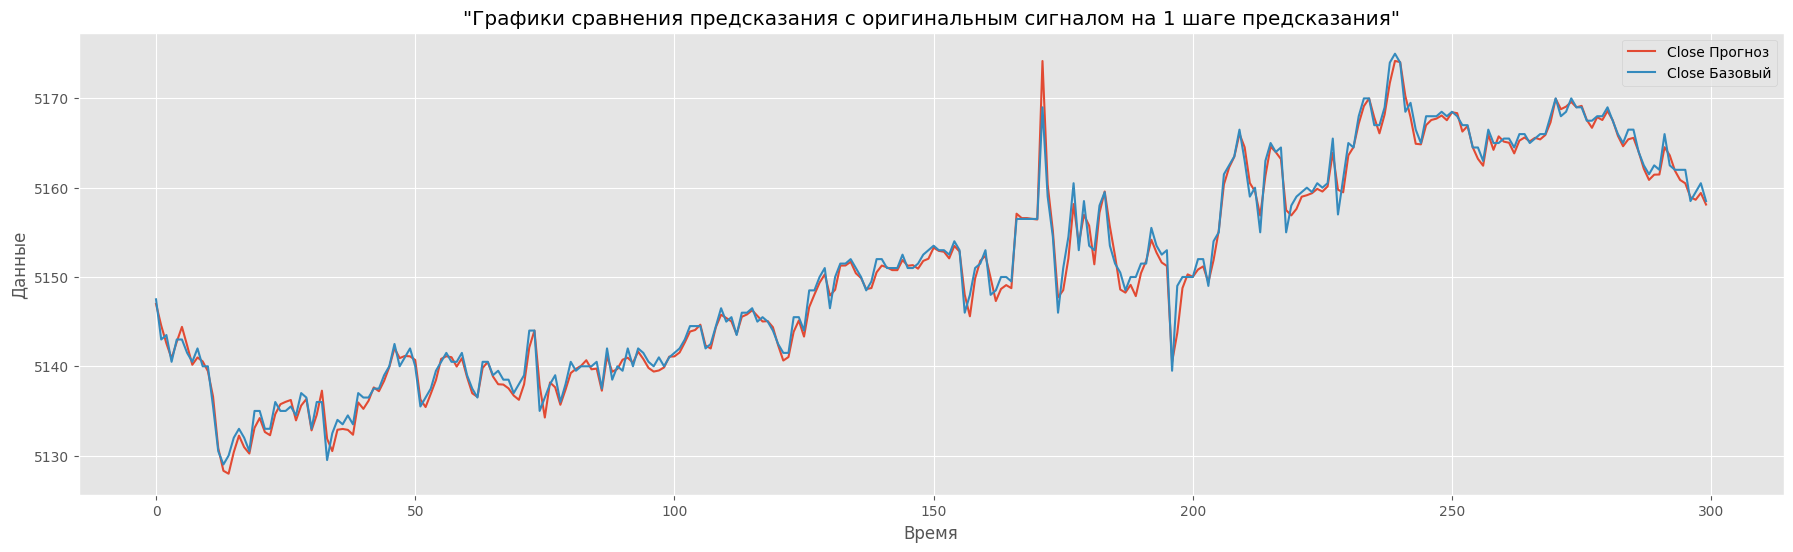

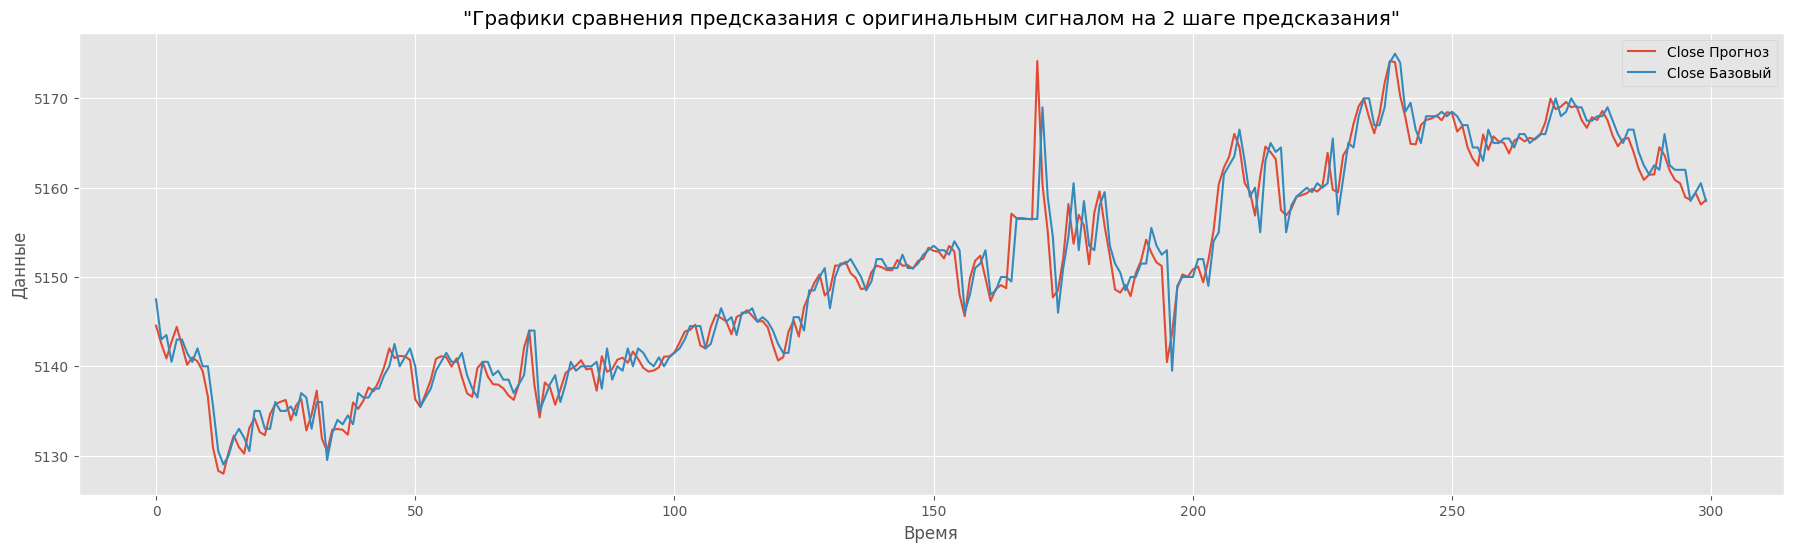

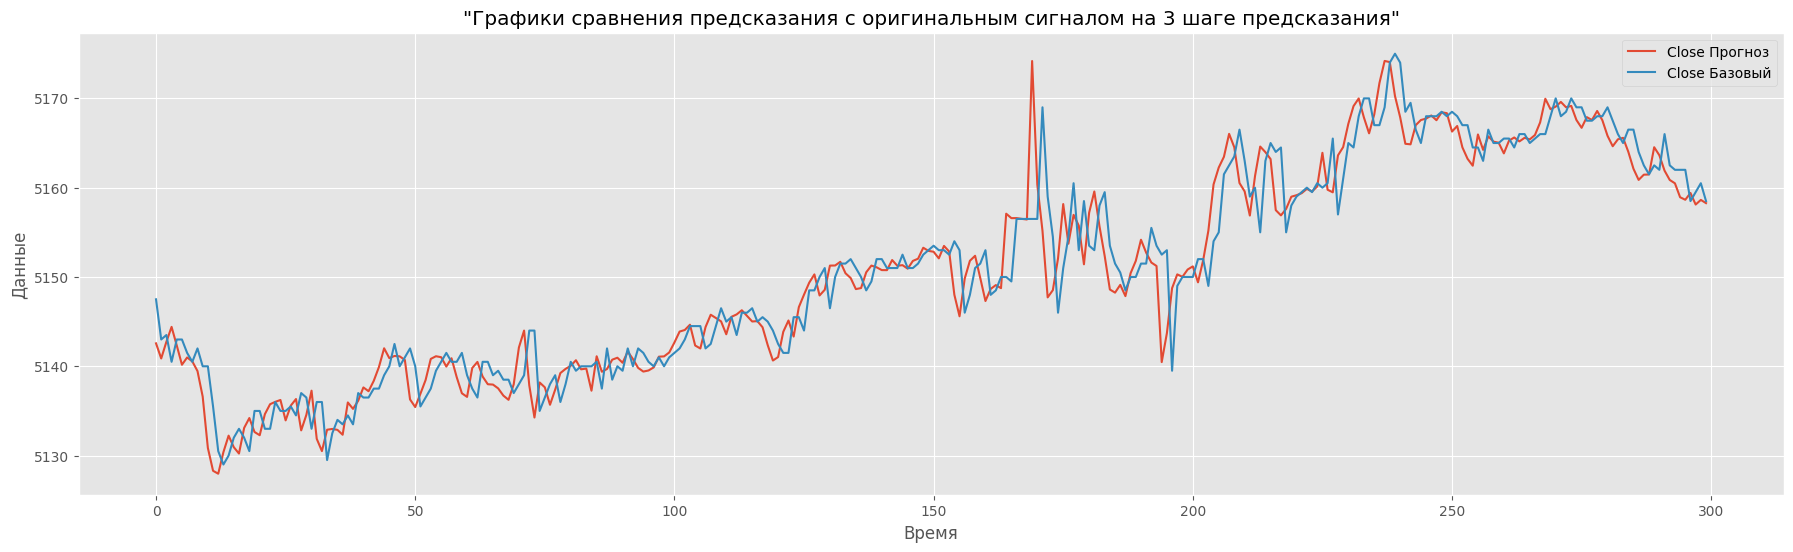

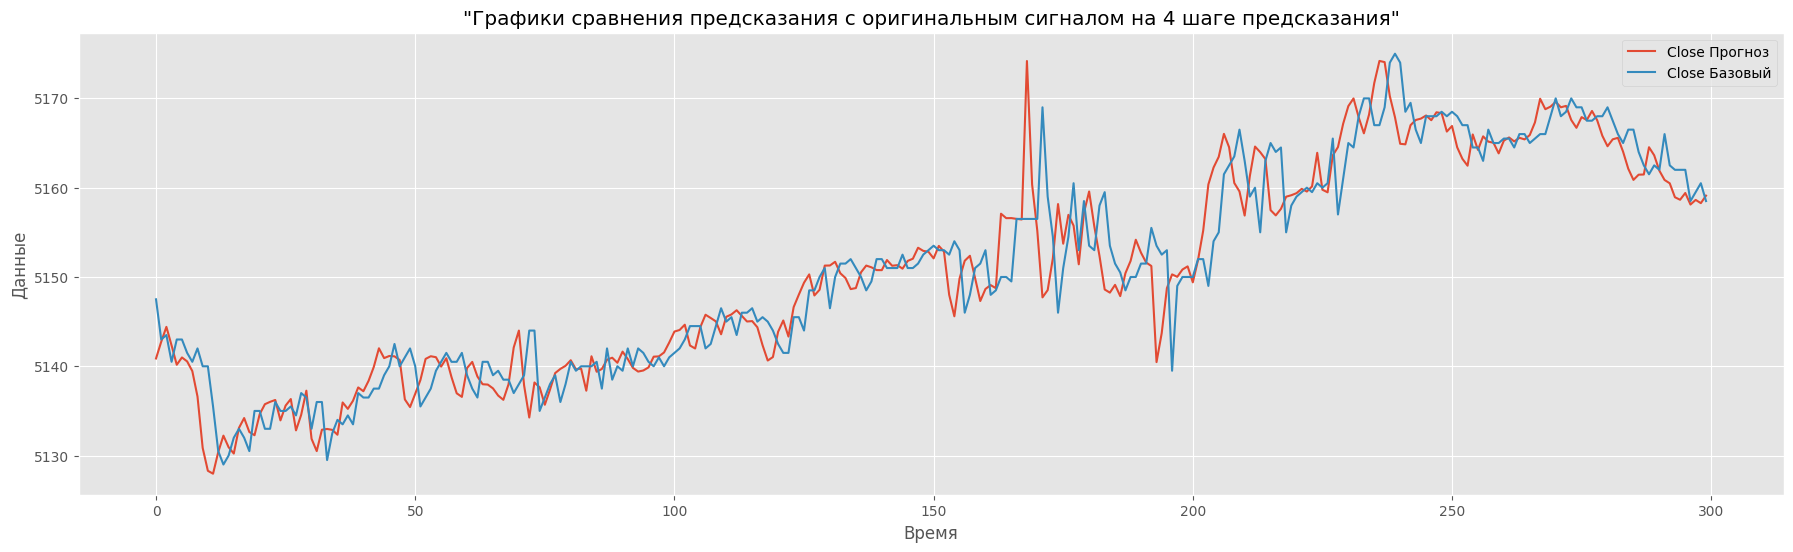

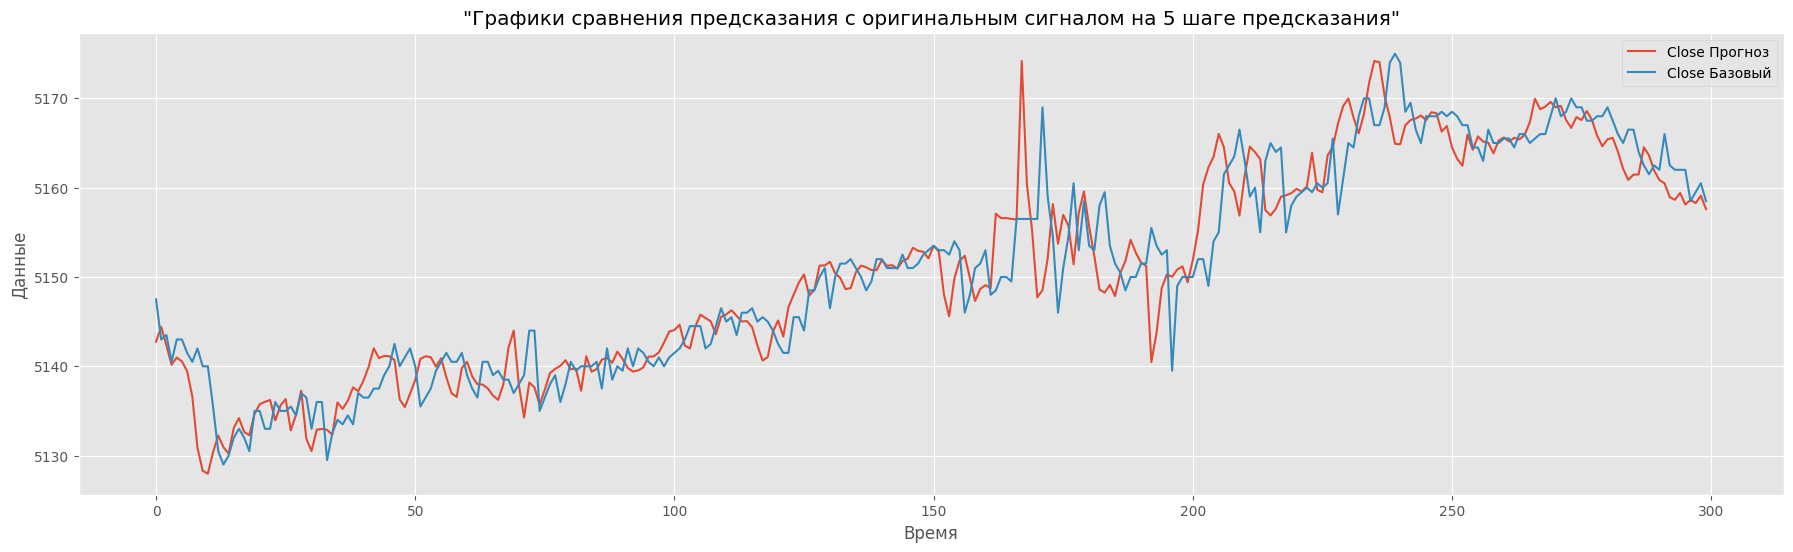

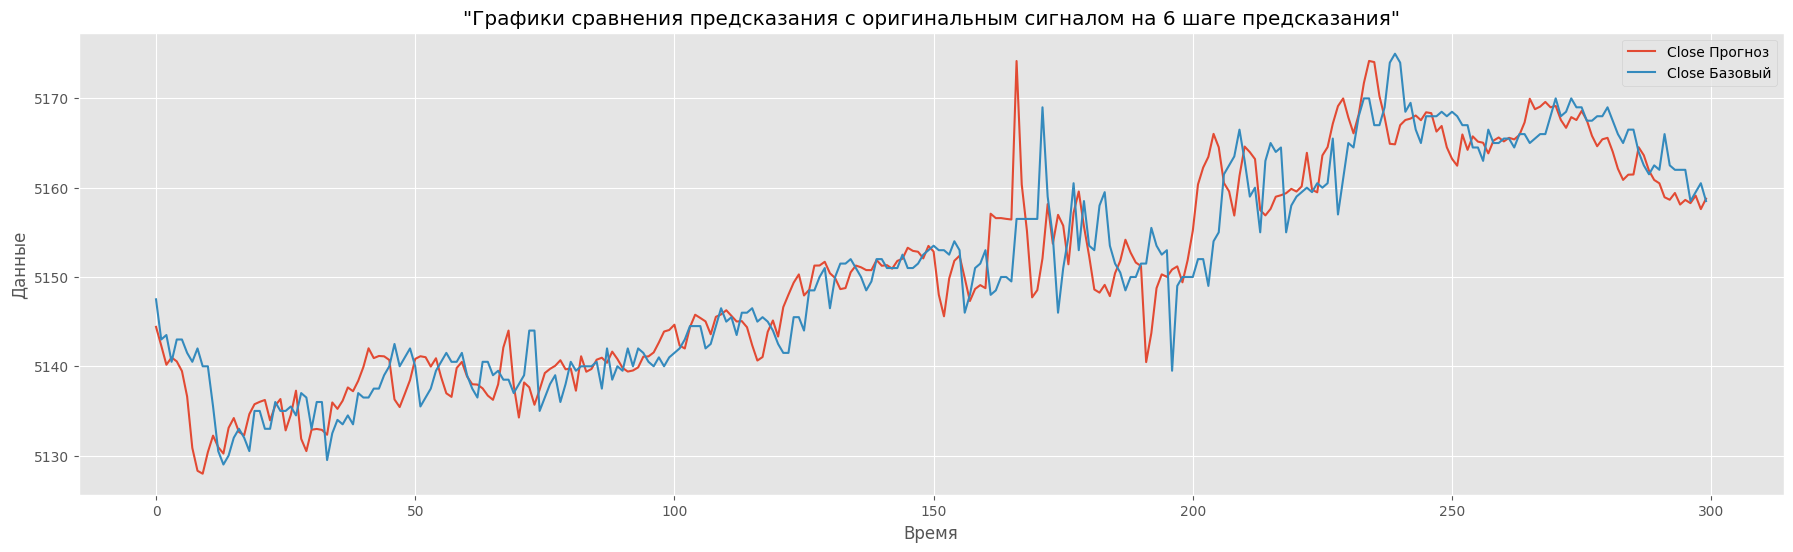

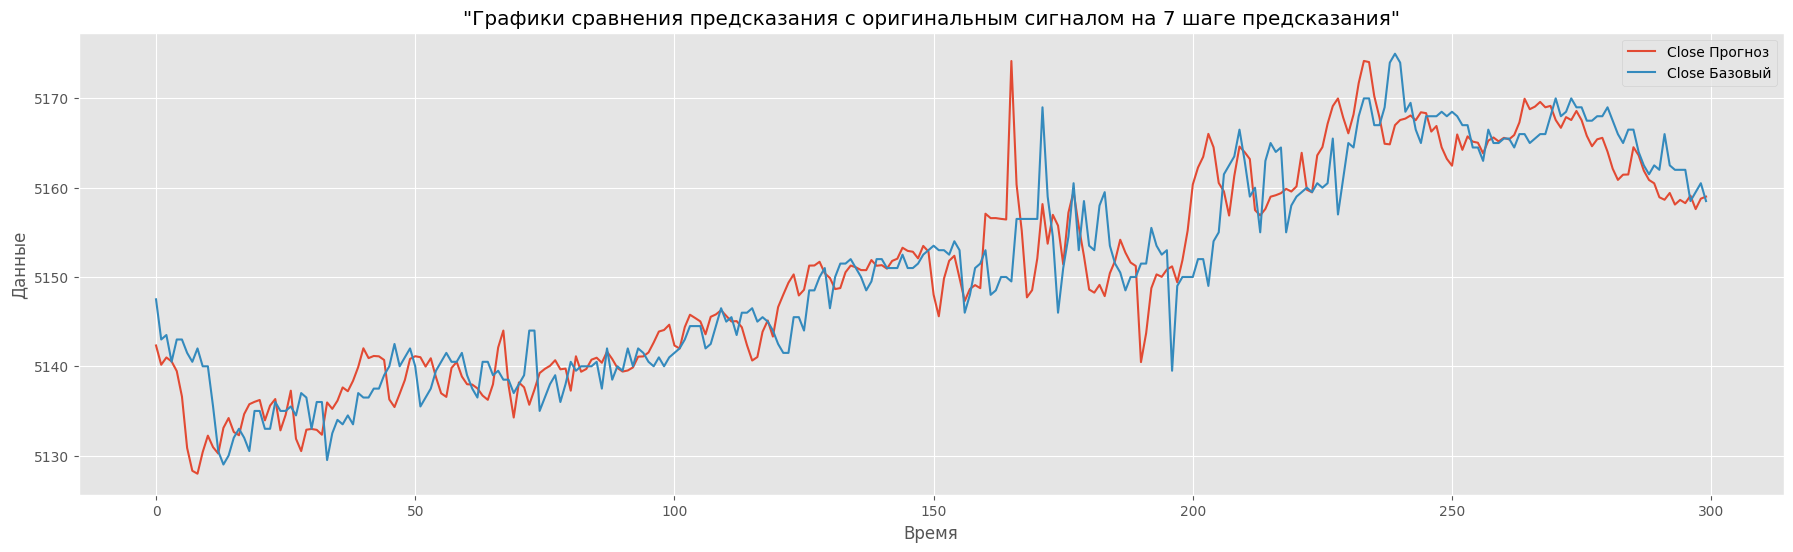

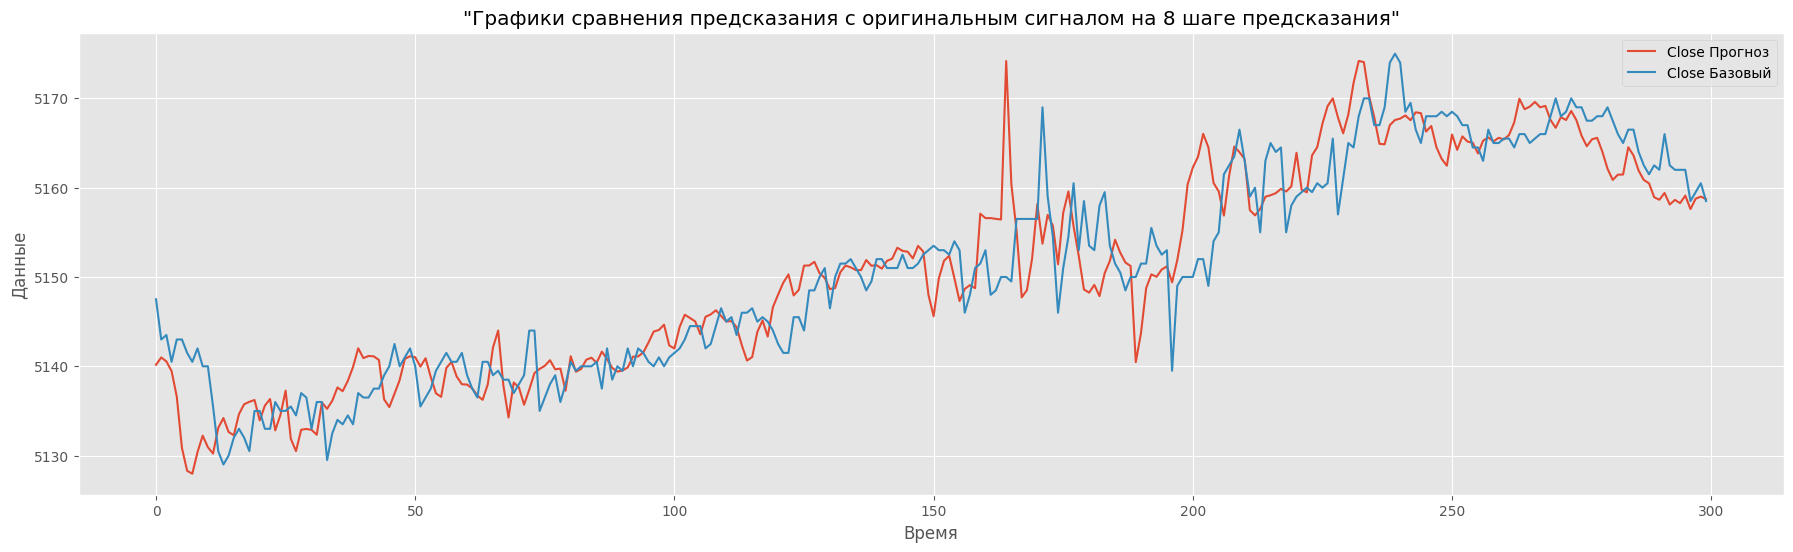

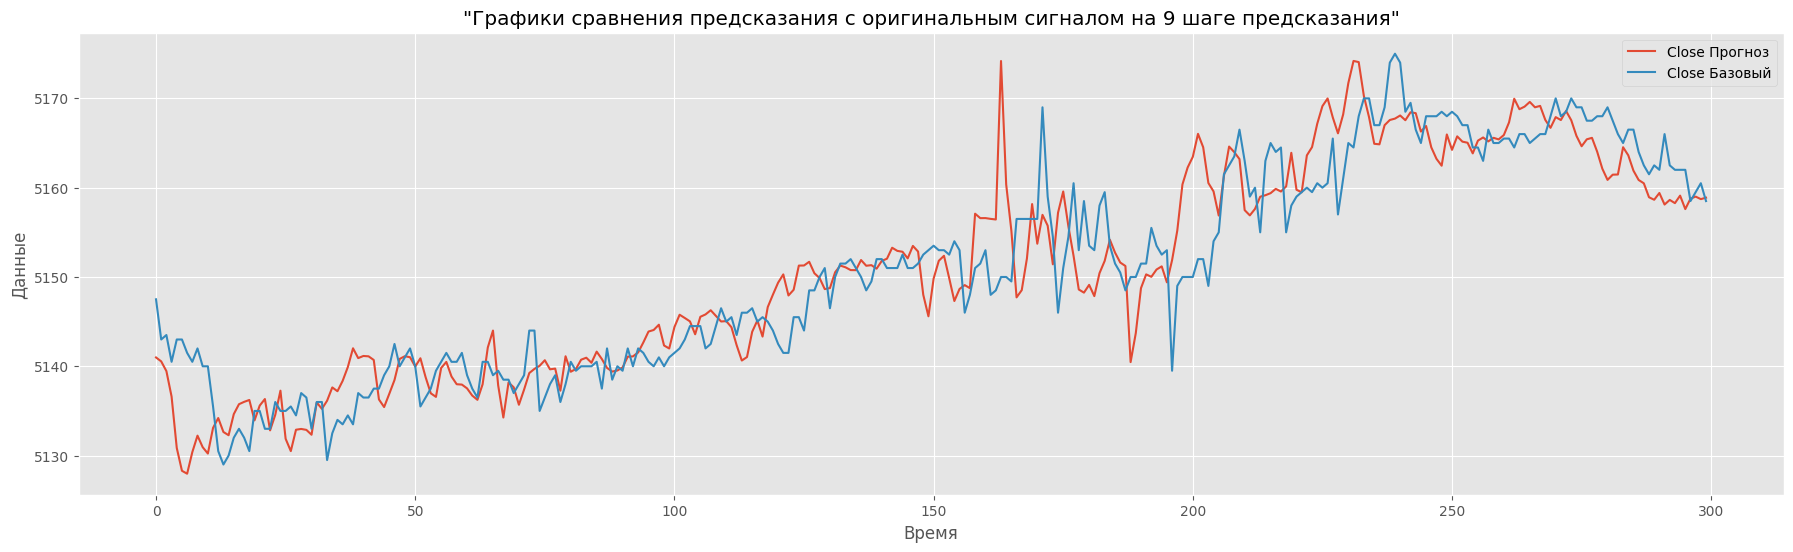

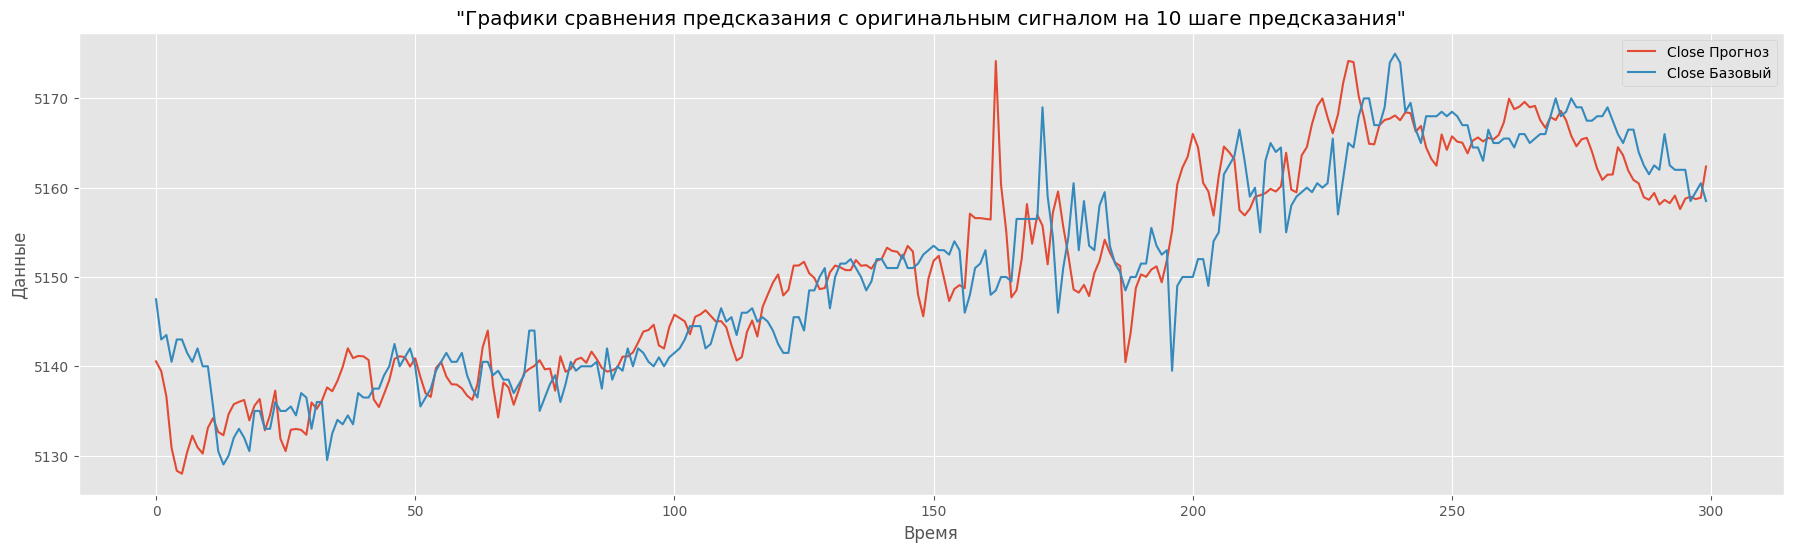

In [ ]:
y_pred = y_scaler.inverse_transform(model_lstm.predict(x_test)) # Вычисление и деномализация предсказания
y_true = y_scaler.inverse_transform(y_test)                     # Денормализация верных ответов

for i in range(1, 11):
  show_predict(y_pred[i:], y_true[:-i], start, length,                        # Отрисовка графика сопоставления базового и прогнозного рядов
              title=f'"Графики сравнения предсказания с оригинальным сигналом на {i} шаге предсказания"')

Кажется она прям повторяет график. Чувак в тг сазал что проверять надо на тестовых выборках которые нейронка даже не видела, ну это то логично, но самому так сразу в голову не пришло, ну а эти тестовые копия валидационых.